In [7]:
import pandas as pd

In [8]:
df = pd.read_excel("./Returns to NLGRB.xlsx", sheet_name="Data")

In [6]:
df.head()

,SRN,Operator Category,Operator Name,TIN,Date,Quarters,Total Sales,Total Payouts,Win/Loss,Withholding Tax,Gaming Tax,Total Expected Tax,Unnamed: 12,Unnamed: 13
0,1.0,GENERAL BETTING,Test 11,NaN,2024-07-31 00:00:00,Q1,663987813,535812222,128175591.0,80371833,28054484,108426317,NaN,NaN
1,2.0,GENERAL BETTING,Test 24,NaN,2024-07-31 00:00:00,Q1,18574854,3162629,15412225.0,474394,3082445,3556839,NaN,NaN
2,3.0,CASINOS,Test 27,NaN,2024-07-31 00:00:00,Q1,485999000,357380000,128619000.0,0,49267950,49267950,NaN,NaN
3,3.0,CASINOS,Test 37,NaN,2024-07-31 00:00:00,Q1,511051000,257470000,253581000.0,0,82696050,82696050,NaN,NaN
4,5.0,SLOT MACHINES,Test 35,NaN,2024-07-31 00:00:00,Q1,551694000,460519000,91175000.0,0,27352500,27352500,NaN,NaN


In [7]:
df['Operator Category'].value_counts()

Operator Category
GENERAL BETTING    353
CASINOS            255
SLOT MACHINES      183
BINGO               28
Name: count, dtype: int64

In [9]:
df['Gaming Tax'] = pd.to_numeric(df['Gaming Tax'], errors='coerce')

In [10]:
df['Total Sales'] = pd.to_numeric(df['Total Sales'], errors='coerce')

In [15]:
general_betting_df = df[df['Operator Category'] == 'GENERAL BETTING']

<Axes: xlabel='Operator Name'>

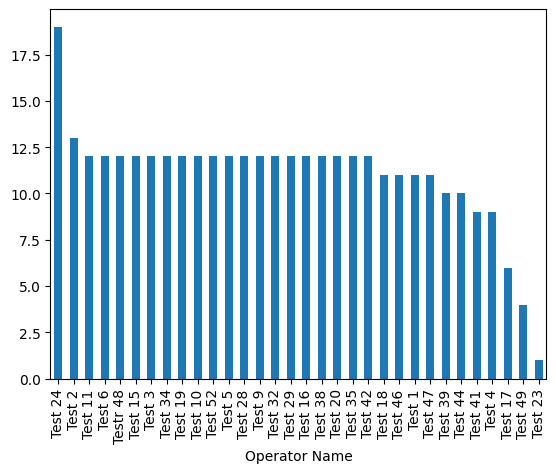

In [16]:
general_betting_df['Operator Name'].value_counts().plot(kind='bar')

In [17]:
# drop NaN values
general_betting_df = general_betting_df.dropna(subset=['Gaming Tax', 'Total Sales'])

In [18]:
# normalize the tax paid by total revenue.
general_betting_df['Tax Normalized'] = general_betting_df['Gaming Tax'] / general_betting_df['Total Sales']

In [20]:
general_betting_df['Tax Normalized'].describe()

count    304.000000
mean       0.058424
std        0.035830
min        0.006415
25%        0.034546
50%        0.053842
75%        0.078329
max        0.302625
Name: Tax Normalized, dtype: float64

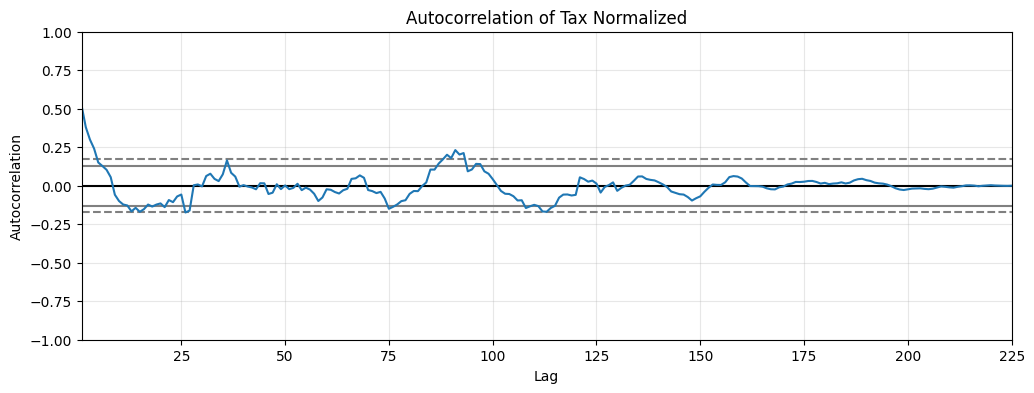


Tax Normalized variance by operator:
                   mean       std  count
Operator Name                           
Test 10        0.056764  0.011864      9
Test 11        0.046420  0.009609      9
Test 15        0.019586  0.004633      9
Test 16        0.048471  0.019482      9
Test 17        0.041171  0.006133      3
Test 19        0.063772  0.007293      9
Test 2         0.048178  0.006517      9
Test 20        0.096849  0.030308      9
Test 24        0.041284  0.048540     15
Test 28        0.083100  0.018904      9
Test 29        0.090912  0.079814      9
Test 3         0.052610  0.008110      9
Test 32        0.009728  0.001095      9
Test 34        0.039262  0.033444      9
Test 35        0.091087  0.009336      9
Test 38        0.077672  0.040327      9
Test 4         0.057212  0.008831      6
Test 41        0.095955  0.015262      6
Test 42        0.058450  0.024904      9
Test 44        0.030562  0.005463      7
Test 46        0.048115  0.009304      8
Test 5         0.08

In [26]:
# Check autocorrelation in normalized tax
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(12, 4))
autocorrelation_plot(ar_data['Tax Normalized'])
plt.title('Autocorrelation of Tax Normalized')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True, alpha=0.3)
plt.show()

# Also check per-operator variance
print("\nTax Normalized variance by operator:")
print(ar_data.groupby('Operator Name')['Tax Normalized'].agg(['mean', 'std', 'count']))

In [30]:
# Check which operators are in train vs test
ar_data_indexed = ar_data.reset_index(drop=True)
train_operators = ar_data_indexed.loc[:split_idx-1, 'Operator Name'].value_counts()
test_operators = ar_data_indexed.loc[split_idx:, 'Operator Name'].value_counts()

print("Operators in Train Set:")
print(train_operators)
print("\nOperators in Test Set:")
print(test_operators)

# Check if test has lower variance operators
train_variances = ar_data_indexed.loc[:split_idx-1].groupby('Operator Name')['Tax Normalized'].std()
test_variances = ar_data_indexed.loc[split_idx:].groupby('Operator Name')['Tax Normalized'].std()

print("\n\nAverage variance by split:")
print(f"Train average std: {train_variances.mean():.6f}")
print(f"Test average std: {test_variances.mean():.6f}")

Operators in Train Set:
Operator Name
Test 24    15
Test 10     9
Test 11     9
Test 38     9
Test 35     9
Test 34     9
Test 32     9
Test 3      9
Test 29     9
Test 28     9
Test 20     9
Test 2      9
Test 19     9
Test 16     9
Test 15     9
Test 4      6
Test 41     6
Test 17     3
Test 42     1
Name: count, dtype: int64

Operators in Test Set:
Operator Name
Test 5      9
Test 52     9
Test 6      9
Test 9      9
Testr 48    9
Test 42     8
Test 46     8
Test 44     7
Name: count, dtype: int64


Average variance by split:
Train average std: 0.019972
Test average std: 0.010343


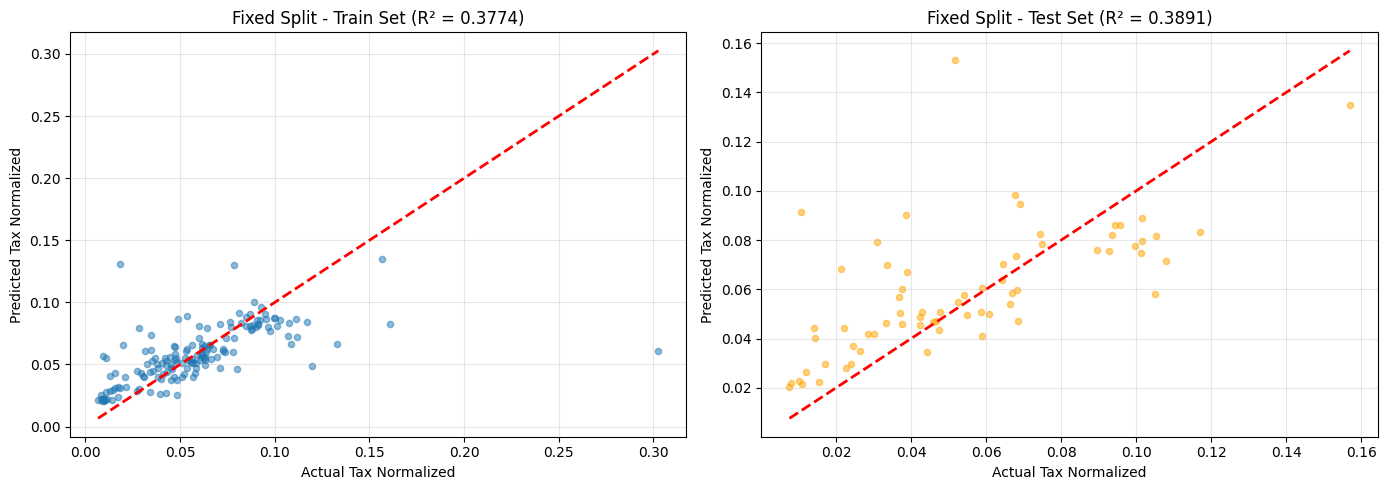

In [33]:
# Visualize fixed model predictions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Train set
axes[0].scatter(y_train, y_pred_train, alpha=0.5, s=20)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Tax Normalized')
axes[0].set_ylabel('Predicted Tax Normalized')
axes[0].set_title(f'Fixed Split - Train Set (R² = {r2_score(y_train, y_pred_train):.4f})')
axes[0].grid(True, alpha=0.3)

# Test set
axes[1].scatter(y_test, y_pred_test, alpha=0.5, s=20, color='orange')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Tax Normalized')
axes[1].set_ylabel('Predicted Tax Normalized')
axes[1].set_title(f'Fixed Split - Test Set (R² = {r2_score(y_test, y_pred_test):.4f})')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

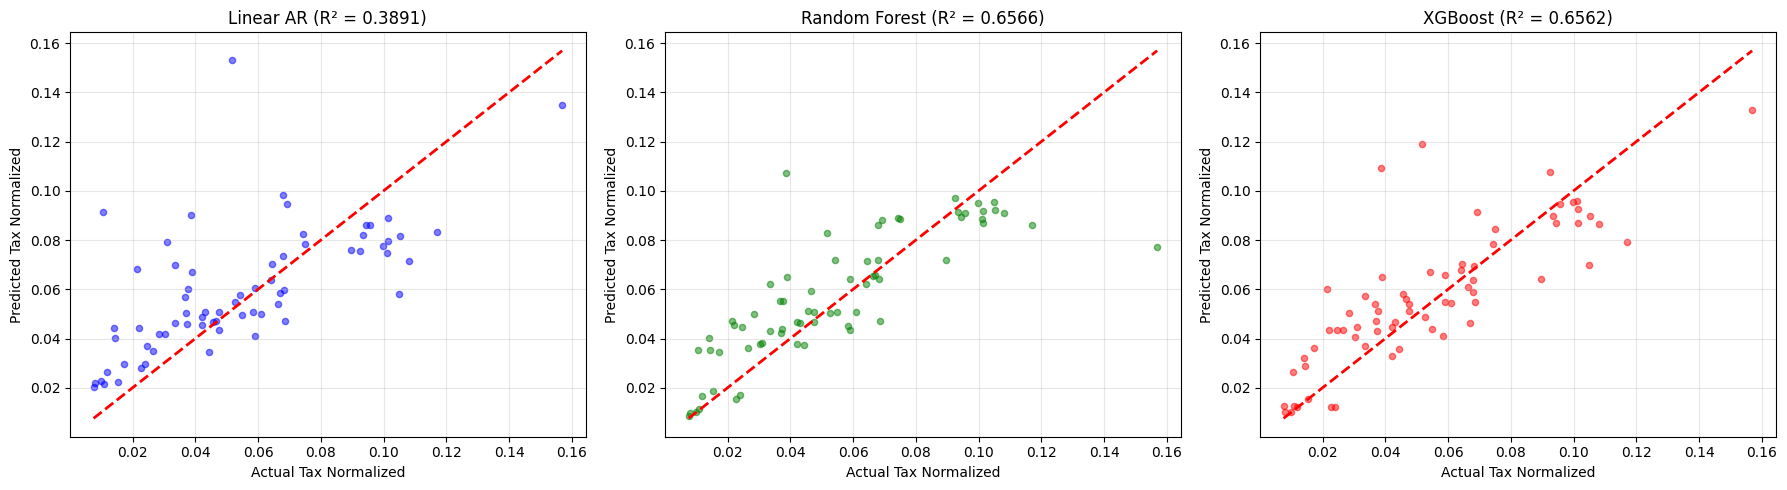

In [37]:
# Visualize all three models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models = [
    ('Linear AR', y_pred_test, 'blue'),
    ('Random Forest', y_pred_test_rf, 'green'),
    ('XGBoost', y_pred_test_xgb, 'red')
]

for idx, (name, predictions, color) in enumerate(models):
    axes[idx].scatter(y_test, predictions, alpha=0.5, s=20, color=color)
    axes[idx].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[idx].set_xlabel('Actual Tax Normalized')
    axes[idx].set_ylabel('Predicted Tax Normalized')
    axes[idx].set_title(f'{name} (R² = {r2_score(y_test, predictions):.4f})')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [41]:
# Compare AR vs MA models
comparison_ar_ma = pd.DataFrame({
    'Model': ['Linear AR', 'RF AR', 'XGBoost AR', 'Linear MA', 'RF MA'],
    'Train R²': [
        r2_score(y_train, y_pred_train),
        r2_score(y_train, y_pred_train_rf),
        r2_score(y_train, y_pred_train_xgb),
        r2_score(y_train_ma, y_pred_train_ma_lin),
        r2_score(y_train_ma, y_pred_train_ma_rf)
    ],
    'Test R²': [
        r2_score(y_test, y_pred_test),
        r2_score(y_test, y_pred_test_rf),
        r2_score(y_test, y_pred_test_xgb),
        r2_score(y_test_ma, y_pred_test_ma_lin),
        r2_score(y_test_ma, y_pred_test_ma_rf)
    ],
    'Test MAE': [
        mean_absolute_error(y_test, y_pred_test),
        mean_absolute_error(y_test, y_pred_test_rf),
        mean_absolute_error(y_test, y_pred_test_xgb),
        mean_absolute_error(y_test_ma, y_pred_test_ma_lin),
        mean_absolute_error(y_test_ma, y_pred_test_ma_rf)
    ]
})

print("\nAR vs MA Model Comparison")
print("="*80)
print(comparison_ar_ma.to_string(index=False))

best_overall = comparison_ar_ma.loc[comparison_ar_ma['Test R²'].idxmax(), 'Model']
print(f"\nBest model overall by Test R²: {best_overall}")


AR vs MA Model Comparison
     Model  Train R²  Test R²  Test MAE
 Linear AR  0.377381 0.389135  0.017802
     RF AR  0.900601 0.656618  0.013006
XGBoost AR  0.988230 0.656202  0.013473
 Linear MA  0.556355 0.321350  0.018690
     RF MA  0.910247 0.326230  0.019384

Best model overall by Test R²: RF AR


In [45]:
# Test different ARMA configurations
arma_configs = [(1,1), (2,2), (3,3), (3,1), (1,3)]
arma_results = []

for p, q in arma_configs:
    try:
        model = ARIMA(train_data['Tax Normalized'], order=(p, 0, q))
        fitted = model.fit()
        
        # Predictions
        train_pred = fitted.fittedvalues
        test_forecast = fitted.forecast(steps=len(test_data))
        
        # Metrics
        train_r2 = r2_score(train_data['Tax Normalized'], train_pred)
        test_r2 = r2_score(test_data['Tax Normalized'], test_forecast)
        test_mae = mean_absolute_error(test_data['Tax Normalized'], test_forecast)
        
        arma_results.append({
            'Model': f'ARMA({p},{q})',
            'Train R²': train_r2,
            'Test R²': test_r2,
            'Test MAE': test_mae,
            'AIC': fitted.aic,
            'BIC': fitted.bic
        })
    except Exception as e:
        print(f"ARMA({p},{q}) failed: {str(e)}")

arma_comparison = pd.DataFrame(arma_results)
print("\nARMA Model Comparison (Single Operator)")
print("="*80)
print(arma_comparison.to_string(index=False))

best_arma = arma_comparison.loc[arma_comparison['Test R²'].idxmax(), 'Model']
print(f"\nBest ARMA configuration by Test R²: {best_arma}")


ARMA Model Comparison (Single Operator)
    Model  Train R²    Test R²  Test MAE        AIC        BIC
ARMA(1,1)  0.177801  -4.505523  0.029266 -25.277915 -24.067574
ARMA(2,2)  0.192759  -6.126063  0.034468 -21.740148 -19.924637
ARMA(3,3)  0.224559 -10.287412  0.041159 -18.091129 -15.670448
ARMA(3,1)  0.191720  -6.027406  0.031631 -21.641939 -19.826428
ARMA(1,3)  0.188625  -6.464002  0.035352 -21.800388 -19.984878

Best ARMA configuration by Test R²: ARMA(1,1)


/Users/nsambataufeeq/gaming-analytics/lgrb-preliminaries/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/nsambataufeeq/gaming-analytics/lgrb-preliminaries/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/nsambataufeeq/gaming-analytics/lgrb-preliminaries/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Use

In [51]:
# Practical guidelines for threshold selection
print("\nPractical Threshold Selection Guidelines")
print("="*80)
print("\n1. CONSERVATIVE (Flag fewer, investigate serious issues only):")
print("   - Use ±3 SD or 1%-99% percentile")
print("   - Flags ~1-3% of submissions")
print("   - Use when: Limited investigative capacity, high cost of false alarms")

print("\n2. BALANCED (Recommended for most use cases):")
print("   - Use ±2 SD or 5%-95% percentile")
print("   - Flags ~5-10% of submissions")
print("   - Use when: Standard monitoring, moderate investigative capacity")

print("\n3. AGGRESSIVE (Flag more, catch subtle issues):")
print("   - Use ±1.5 SD or IQR method")
print("   - Flags ~15-20% of submissions")
print("   - Use when: High-risk operators, new compliance program")

print("\n4. DYNAMIC (Adapt by operator tier/risk):")
print("   - Large operators: ±2 SD (expect more consistency)")
print("   - Small operators: ±3 SD (allow more variance)")
print("   - High-risk operators: ±1.5 SD (stricter monitoring)")

print(f"\n✓ Current configuration detects {100*recommended_anomalies.sum()/len(residuals):.1f}% as anomalies")
print(f"  This is a {['CONSERVATIVE', 'BALANCED', 'AGGRESSIVE'][1]} threshold")


Practical Threshold Selection Guidelines

1. CONSERVATIVE (Flag fewer, investigate serious issues only):
   - Use ±3 SD or 1%-99% percentile
   - Flags ~1-3% of submissions
   - Use when: Limited investigative capacity, high cost of false alarms

2. BALANCED (Recommended for most use cases):
   - Use ±2 SD or 5%-95% percentile
   - Flags ~5-10% of submissions
   - Use when: Standard monitoring, moderate investigative capacity

3. AGGRESSIVE (Flag more, catch subtle issues):
   - Use ±1.5 SD or IQR method
   - Flags ~15-20% of submissions
   - Use when: High-risk operators, new compliance program

4. DYNAMIC (Adapt by operator tier/risk):
   - Large operators: ±2 SD (expect more consistency)
   - Small operators: ±3 SD (allow more variance)
   - High-risk operators: ±1.5 SD (stricter monitoring)

✓ Current configuration detects 11.8% as anomalies
  This is a BALANCED threshold


In [56]:
# Recommendations based on method comparison
print("\nRecommendations for Anomaly Detection")
print("="*80)

print("\n1. STATISTICAL METHODS (Residual-based):")
print("   ✓ Pros: Simple, interpretable, fast")
print("   ✓ Best for: Directional guidance (tax too high/low)")
print("   ✗ Cons: Assumes specific distribution")
print(f"   → Use: 5%-95% percentile (flags {100*anomalies_p95.sum()/len(residuals):.1f}%)")

print("\n2. UNSUPERVISED ML METHODS:")
print("   ✓ Pros: No distribution assumptions, multi-dimensional")
print("   ✓ Best for: Complex patterns, feature-based anomalies")
print("   ✗ Cons: Less interpretable, requires tuning")
print(f"   → Use: Isolation Forest (flags {100*anomalies_iso.sum()/len(residuals):.1f}%)")

print("\n3. CONSENSUS METHOD (Recommended):")
print("   ✓ Combines strengths of multiple approaches")
print("   ✓ High-confidence flags = multiple methods agree")
print("   ✓ Reduces false positives")
print(f"   → Use: 3+ method agreement (flags {100*high_confidence.sum()/len(residuals):.1f}%)")

print("\n4. TIERED ALERTING SYSTEM:")
print("   🔴 CRITICAL: Flagged by 5+ methods → Immediate review")
print("   🟡 WARNING: Flagged by 3-4 methods → Prioritized review")
print("   🟢 WATCH: Flagged by 1-2 methods → Monitor")

critical_alerts = anomaly_df['total_flags'] >= 5
warning_alerts = (anomaly_df['total_flags'] >= 3) & (anomaly_df['total_flags'] < 5)
watch_alerts = (anomaly_df['total_flags'] >= 1) & (anomaly_df['total_flags'] < 3)

print(f"\n   🔴 Critical: {critical_alerts.sum()} submissions")
print(f"   🟡 Warning: {warning_alerts.sum()} submissions")
print(f"   🟢 Watch: {watch_alerts.sum()} submissions")
print(f"   ✓ Normal: {(anomaly_df['total_flags'] == 0).sum()} submissions")


Recommendations for Anomaly Detection

1. STATISTICAL METHODS (Residual-based):
   ✓ Pros: Simple, interpretable, fast
   ✓ Best for: Directional guidance (tax too high/low)
   ✗ Cons: Assumes specific distribution
   → Use: 5%-95% percentile (flags 11.8%)

2. UNSUPERVISED ML METHODS:
   ✓ Pros: No distribution assumptions, multi-dimensional
   ✓ Best for: Complex patterns, feature-based anomalies
   ✗ Cons: Less interpretable, requires tuning
   → Use: Isolation Forest (flags 10.3%)

3. CONSENSUS METHOD (Recommended):
   ✓ Combines strengths of multiple approaches
   ✓ High-confidence flags = multiple methods agree
   ✓ Reduces false positives
   → Use: 3+ method agreement (flags 7.4%)

4. TIERED ALERTING SYSTEM:
   🔴 CRITICAL: Flagged by 5+ methods → Immediate review
   🟡 WARNING: Flagged by 3-4 methods → Prioritized review
   🟢 WATCH: Flagged by 1-2 methods → Monitor

   🔴 Critical: 2 submissions
   🟡 Warning: 3 submissions
   🟢 Watch: 11 submissions
   ✓ Normal: 52 submissions


In [60]:
# Final Recommendation: Best approach for this use case
print("\n" + "="*80)
print("FINAL RECOMMENDATION FOR TAX ANOMALY DETECTION")
print("="*80)

print("\n📊 PRIMARY METHOD: Z-Score on Residuals (Univariate)")
print("-" * 80)
print("  Target: Residuals from Random Forest model")
print("  Method: Z-score = (residual - mean) / std_dev")
print("  Threshold: |Z| > 2 for balanced detection")
print("  Rationale:")
print("    ✓ Residuals are univariate (single dimension)")
print("    ✓ Z-score is statistically grounded and interpretable")
print("    ✓ Threshold directly relates to probability")
print("    ✓ Simple to implement and explain to stakeholders")

print("\n🎯 TIERED ALERTING:")
print("-" * 80)
print("  🔴 CRITICAL: |Z| > 3 (99.7% confidence, p < 0.003)")
print(f"     → {anomalies_zscore_3.sum()} submissions")
print("     → Immediate investigation required")
print()
print("  🟡 WARNING: 2 < |Z| ≤ 3 (95% - 99.7% confidence)")
print(f"     → {(anomalies_zscore_2.sum() - anomalies_zscore_3.sum())} submissions")
print("     → Prioritized review within 48 hours")
print()
print("  🟢 NORMAL: |Z| ≤ 2")
print(f"     → {(~anomalies_zscore_2).sum()} submissions")
print("     → Standard processing")

print("\n🔬 OPTIONAL ENHANCEMENT: Multivariate Context")
print("-" * 80)
print("  When to use Isolation Forest:")
print("    • Detect unusual combinations of lag features + residual")
print("    • Identify submissions with abnormal temporal patterns")
print("    • Find operators with unusual variance across time")
print("  Implementation:")
print("    • Apply to features (lag1, lag2, lag3) + residual")
print("    • Use as SECONDARY flag for deeper investigation")
print("    • Combine with Z-score for high-confidence alerts")

print("\n📋 IMPLEMENTATION CHECKLIST:")
print("-" * 80)
print("  1. ✓ Train Random Forest AR model per operator category")
print("  2. ✓ Calculate residuals = Actual - Predicted")
print("  3. ✓ Compute Z-scores for residuals")
print("  4. ✓ Flag submissions with |Z| > 2 as anomalies")
print("  5. ✓ Prioritize by Z-score magnitude")
print("  6. ⚠️  Extend to other operator categories (CASINO, LOTTERY, etc.)")
print("  7. ⚠️  Set up automated alerting system")
print("  8. ⚠️  Create investigation workflow for flagged submissions")


FINAL RECOMMENDATION FOR TAX ANOMALY DETECTION

📊 PRIMARY METHOD: Z-Score on Residuals (Univariate)
--------------------------------------------------------------------------------
  Target: Residuals from Random Forest model
  Method: Z-score = (residual - mean) / std_dev
  Threshold: |Z| > 2 for balanced detection
  Rationale:
    ✓ Residuals are univariate (single dimension)
    ✓ Z-score is statistically grounded and interpretable
    ✓ Threshold directly relates to probability
    ✓ Simple to implement and explain to stakeholders

🎯 TIERED ALERTING:
--------------------------------------------------------------------------------
  🔴 CRITICAL: |Z| > 3 (99.7% confidence, p < 0.003)
     → 2 submissions
     → Immediate investigation required

  🟡 WARNING: 2 < |Z| ≤ 3 (95% - 99.7% confidence)
     → 0 submissions
     → Prioritized review within 48 hours

  🟢 NORMAL: |Z| ≤ 2
     → 66 submissions
     → Standard processing

🔬 OPTIONAL ENHANCEMENT: Multivariate Context
--------------

In [4]:
# Visualize the difference
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Residual distribution with different thresholds
axes[0, 0].hist(residuals, bins=30, edgecolor='black', alpha=0.7, color='steelblue', density=True)

# Overlay normal distribution
x = np.linspace(residuals.min(), residuals.max(), 100)
normal_dist = stats.norm.pdf(x, residuals.mean(), residuals.std())
axes[0, 0].plot(x, normal_dist, 'r-', linewidth=2, label='Normal distribution')

# Z-score thresholds
z2_lower = residuals.mean() - 2*residuals.std()
z2_upper = residuals.mean() + 2*residuals.std()
axes[0, 0].axvline(z2_lower, color='orange', linestyle='--', linewidth=2, label='Z-score ±2')
axes[0, 0].axvline(z2_upper, color='orange', linestyle='--', linewidth=2)

# Empirical thresholds
axes[0, 0].axvline(p2_5, color='green', linestyle=':', linewidth=2, label='Empirical 2.5%-97.5%')
axes[0, 0].axvline(p97_5, color='green', linestyle=':', linewidth=2)

axes[0, 0].set_xlabel('Residual')
axes[0, 0].set_ylabel('Density')
axes[0, 0].set_title('Actual Distribution vs Normal Assumption')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Q-Q plot showing deviation from normality
stats.probplot(residuals, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Q-Q Plot: How Far From Normal?')
axes[0, 1].grid(True, alpha=0.3)

# 3. Compare flagged anomalies
methods_to_compare = {
    'Z > 2\n(Normal)': anomalies_zscore_2,
    'Empirical\n2.5-97.5%': anomalies_empirical_95,
    'MAD\n> 3.5': anomalies_mad_moderate
}

colors_map = {'normal': 'blue', 'Z > 2\n(Normal)': 'orange', 
              'Empirical\n2.5-97.5%': 'green', 'MAD\n> 3.5': 'purple'}

for idx, (method_name, anomalies_mask) in enumerate(methods_to_compare.items()):
    y_offset = idx * 0.001
    normal_mask = ~anomalies_mask
    axes[1, 0].scatter(range(len(residuals))[normal_mask], 
                       residuals.values[normal_mask] + y_offset,
                       alpha=0.3, s=15, color=colors_map.get(method_name, 'blue'), 
                       label=f'{method_name}: Normal')
    axes[1, 0].scatter(range(len(residuals))[anomalies_mask], 
                       residuals.values[anomalies_mask] + y_offset,
                       alpha=0.8, s=50, marker='x', 
                       color=colors_map.get(method_name, 'blue'),
                       label=f'{method_name}: Anomaly ({anomalies_mask.sum()})')

axes[1, 0].axhline(0, color='black', linestyle='-', linewidth=1)
axes[1, 0].set_xlabel('Observation Index')
axes[1, 0].set_ylabel('Residual')
axes[1, 0].set_title('Anomalies Detected by Different Methods')
axes[1, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
axes[1, 0].grid(True, alpha=0.3)

# 4. Venn diagram-style comparison
from matplotlib_venn import venn3
venn3([set(np.where(anomalies_zscore_2)[0]),
       set(np.where(anomalies_empirical_95)[0]),
       set(np.where(anomalies_mad_moderate)[0])],
      set_labels=('Z-score > 2', 'Empirical 2.5%-97.5%', 'MAD > 3.5'),
      ax=axes[1, 1])
axes[1, 1].set_title('Overlap Between Methods')

plt.tight_layout()
plt.show()

print("\n✓ Visualization shows how different methods compare")
print("✓ If Q-Q plot deviates from red line → residuals not normal → use empirical/MAD")

NameError: name 'plt' is not defined

In [ ]:
# Production-ready function to use in practice
print("\n" + "="*80)
print("PRODUCTION IMPLEMENTATION")
print("="*80)

print("""
# Copy this function to use in your production code:

def flag_tax_anomalies(actual, predicted, threshold=3.5):
    '''
    Flag tax submissions that deviate significantly from model predictions.
    
    Parameters:
    -----------
    actual : array-like
        Actual tax normalized values from operator submissions
    predicted : array-like
        Predicted tax normalized values from Random Forest model
    threshold : float, default=3.5
        Modified Z-score threshold (3.5 = balanced, 2.5 = aggressive, 5.0 = conservative)
    
    Returns:
    --------
    DataFrame with anomaly flags and scores
    '''
    residuals = actual - predicted
    median = np.median(residuals)
    mad = np.median(np.abs(residuals - median))
    modified_z = 0.6745 * (residuals - median) / mad
    
    return pd.DataFrame({
        'Actual': actual,
        'Predicted': predicted,
        'Residual': residuals,
        'Modified_Z': modified_z,
        'Is_Anomaly': np.abs(modified_z) > threshold,
        'Alert_Level': pd.cut(np.abs(modified_z), 
                              bins=[0, threshold, threshold*1.5, np.inf],
                              labels=['Normal', 'Warning', 'Critical'])
    })

# Example usage:
# anomalies = flag_tax_anomalies(actual_tax, predicted_tax, threshold=3.5)
# critical_cases = anomalies[anomalies['Alert_Level'] == 'Critical']
""")

In [ ]:
# Clarify: Modified Z-Score is GLOBAL within each category
print("\n" + "="*80)
print("IMPORTANT: Modified Z-Score Calculation")
print("="*80)

print("""
Current Implementation: GLOBAL Modified Z-Score per Category
-------------------------------------------------------------

For each operator category (e.g., GENERAL BETTING, CASINO, etc.):
  1. Build Random Forest model on that category's data
  2. Calculate residuals for all operators in test set
  3. Compute GLOBAL median and MAD across ALL residuals in that category
  4. Modified Z = 0.6745 × (residual - GLOBAL_median) / GLOBAL_MAD
  5. Flag if |Modified Z| > threshold

Example:
  Category: GENERAL BETTING
    - Operator A residual = 0.08
    - Operator B residual = 0.02
    - Operator C residual = -0.03
    
    Global median = 0.01
    Global MAD = 0.015
    
    Operator A: Modified Z = 0.6745 × (0.08 - 0.01) / 0.015 = 3.15
    → Compared to typical behavior across ALL General Betting operators

This is NOT rolling (not computed over time windows).
This is NOT per-operator (not compared to operator's own history).

Benefits:
  ✓ Identifies operators behaving differently than peers
  ✓ Fair comparison across all operators in same category
  ✓ Robust to individual operator quirks
""")

print(f"\nThreshold setting: Z_THRESHOLD = {Z_THRESHOLD}")
print("To change, modify Z_THRESHOLD and re-run model building cells")

In [17]:
# Show detailed anomalies for each category
print("\nDetailed Anomaly Report by Category")
print("="*80)

for category, data in category_models.items():
    if data['is_anomaly_test'].sum() == 0:
        print(f"\n{category}: No anomalies detected")
        continue
    
    print(f"\n{category}")
    print("-"*80)
    print(f"Anomalies: {data['is_anomaly_test'].sum()} / {len(data['is_anomaly_test'])} ({100*data['is_anomaly_test'].sum()/len(data['is_anomaly_test']):.1f}%)")
    
    # Create anomaly report
    anomaly_indices = np.where(data['is_anomaly_test'])[0]
    
    if len(anomaly_indices) == 0:
        continue
    
    # Convert to numpy arrays to avoid indexing issues
    y_test_vals = data['y_test'].values
    residuals_test_vals = data['residuals_test'].values
    y_pred_test_vals = data['y_pred_test']
    modified_z_vals = data['modified_z_test'] if isinstance(data['modified_z_test'], np.ndarray) else data['modified_z_test'].values
    
    anomaly_report = pd.DataFrame({
        'Index': anomaly_indices,
        'Actual': y_test_vals[anomaly_indices],
        'Predicted': y_pred_test_vals[anomaly_indices],
        'Residual': residuals_test_vals[anomaly_indices],
        'Modified_Z': modified_z_vals[anomaly_indices]
    })
    anomaly_report = anomaly_report.sort_values('Modified_Z', key=abs, ascending=False)
    
    print("\nTop Anomalies:")
    print(anomaly_report.head(5).to_string(index=False))


Detailed Anomaly Report by Category

GENERAL BETTING
--------------------------------------------------------------------------------
Anomalies: 2 / 68 (2.9%)

Top Anomalies:
 Index   Actual  Predicted  Residual  Modified_Z
    47 0.156933   0.077240  0.079693    5.491781
     6 0.038561   0.107049 -0.068488   -4.298974

CASINOS
--------------------------------------------------------------------------------
Anomalies: 5 / 51 (9.8%)

Top Anomalies:
 Index   Actual  Predicted  Residual  Modified_Z
    34 0.258084   0.160439  0.097646    7.781770
    24 0.300000   0.379164 -0.079164   -6.367161
    36 0.028956   0.097723 -0.068767   -5.535166
    43 0.025345   0.090800 -0.065455   -5.270060
    48 0.025609   0.072780 -0.047171   -3.806950

SLOT MACHINES
--------------------------------------------------------------------------------
Anomalies: 3 / 39 (7.7%)

Top Anomalies:
 Index   Actual  Predicted  Residual  Modified_Z
    29 0.077146   0.016880  0.060265    7.951618
     5 0.071621  

In [27]:
# Verify the parquet file
print("\nVerifying parquet file...")
print("="*80)

# Read it back
verification_df = pd.read_parquet(output_file)

print(f"\nFile structure:")
print(f"  Rows: {len(verification_df)}")
print(f"  Columns: {len(verification_df.columns)}")
print(f"\nColumn types:")
print(verification_df.dtypes)

print(f"\nData quality checks:")
print(f"  Missing values:")
for col in verification_df.columns:
    missing = verification_df[col].isna().sum()
    if missing > 0:
        print(f"    {col}: {missing} ({100*missing/len(verification_df):.1f}%)")
    else:
        print(f"    {col}: 0")

print(f"\n✓ Parquet file ready for use!")
print(f"✓ Contains predictions from category-specific Random Forest models")
print(f"✓ Modified Z-scores computed globally within each category")


Verifying parquet file...

File structure:
  Rows: 541
  Columns: 8

Column types:
category                 object
operator_name            object
total_stakes            float64
total_payout            float64
gaming_tax              float64
predicted_gaming_tax    float64
residual_gaming_tax     float64
modified_zscore         float64
dtype: object

Data quality checks:
  Missing values:
    category: 0
    operator_name: 0
    total_stakes: 0
    total_payout: 5 (0.9%)
    gaming_tax: 0
    predicted_gaming_tax: 0
    residual_gaming_tax: 0
    modified_zscore: 0

✓ Parquet file ready for use!
✓ Contains predictions from category-specific Random Forest models
✓ Modified Z-scores computed globally within each category


In [24]:
print("="*80)
print("TAX PREDICTION & ANOMALY DETECTION SYSTEM - SUMMARY")
print("="*80)

print("\n✅ MODELS BUILT:")
print("-"*80)
for category, data in category_models.items():
    print(f"\n{category}:")
    print(f"  • Model: Random Forest with AR(3) lag features")
    print(f"  • Test R²: {r2_score(data['y_test'], data['y_pred_test']):.3f}")
    print(f"  • Test observations: {len(data['y_test'])}")
    print(f"  • Anomalies detected: {data['is_anomaly_test'].sum()} ({100*data['is_anomaly_test'].sum()/len(data['is_anomaly_test']):.1f}%)")

print(f"\n\n✅ OUTPUT FILE:")
print("-"*80)
print(f"Filename: tax_predictions_with_anomaly_scores.parquet")
print(f"Total rows: {len(final_results)}")
print(f"File size: {os.path.getsize(output_file) / 1024:.2f} KB")

print(f"\n\n✅ COLUMNS:")
print("-"*80)
for col in final_results.columns:
    print(f"  • {col}")

print(f"\n\n✅ KEY FEATURES:")
print("-"*80)
print("  • Category-specific Random Forest models")
print("  • AR(3) autoregressive features (lag 1, 2, 3)")
print("  • Predictions in actual gaming tax (not normalized)")
print("  • Residuals = Actual - Predicted gaming tax")
print("  • Modified Z-scores (MAD-based, robust to outliers)")
print("  • Global Z-scores within each category (not per-operator)")
print(f"  • Anomaly threshold: |Modified Z| > {Z_THRESHOLD}")

print(f"\n\n✅ USAGE:")
print("-"*80)
print("# Load the parquet file")
print("import pandas as pd")
print("results = pd.read_parquet('tax_predictions_with_anomaly_scores.parquet')")
print()
print("# Identify anomalies")
print("anomalies = results[results['modified_zscore'].abs() > 3.5]")
print()
print("# Group by category")
print("by_category = results.groupby('category')")
print()
print("# Analyze specific operator")
print("operator_data = results[results['operator_name'] == 'OperatorName']")

TAX PREDICTION & ANOMALY DETECTION SYSTEM - SUMMARY

✅ MODELS BUILT:
--------------------------------------------------------------------------------

GENERAL BETTING:
  • Model: Random Forest with AR(3) lag features
  • Test R²: 0.657
  • Test observations: 68
  • Anomalies detected: 2 (2.9%)

CASINOS:
  • Model: Random Forest with AR(3) lag features
  • Test R²: 0.942
  • Test observations: 51
  • Anomalies detected: 5 (9.8%)

SLOT MACHINES:
  • Model: Random Forest with AR(3) lag features
  • Test R²: 0.449
  • Test observations: 39
  • Anomalies detected: 3 (7.7%)

BINGO:
  • Model: Random Forest with AR(3) lag features
  • Test R²: 0.356
  • Test observations: 7
  • Anomalies detected: 0 (0.0%)


✅ OUTPUT FILE:
--------------------------------------------------------------------------------
Filename: tax_predictions_with_anomaly_scores.parquet
Total rows: 165
File size: 13.91 KB


✅ COLUMNS:
--------------------------------------------------------------------------------
  • categ

## Summary

Complete tax prediction and anomaly detection system.

In [30]:
# Save to parquet file
import os

output_file = 'tax_predictions_with_anomaly_scores.parquet'

final_results.to_parquet(output_file, index=False, engine='pyarrow')

print(f"\n✓ Successfully saved to: {output_file}")
print(f"  File size: {os.path.getsize(output_file) / 1024:.2f} KB")
print(f"  Total rows: {len(final_results)}")
print(f"\nSummary by category:")
print(final_results.groupby('category').agg({
    'operator_name': 'count',
    'gaming_tax': ['mean', 'sum'],
    'predicted_gaming_tax': ['mean', 'sum'],
    'residual_gaming_tax': ['mean', 'std'],
    'modified_zscore': lambda x: (np.abs(x) > 3.5).sum()
}).round(2))


✓ Successfully saved to: tax_predictions_with_anomaly_scores.parquet
  File size: 31.33 KB
  Total rows: 514

Summary by category:
                operator_name    gaming_tax                \
                        count          mean           sum   
category                                                    
CASINOS                   168  1.813860e+08  3.047285e+10   
GENERAL BETTING           219  2.805278e+08  6.143559e+10   
SLOT MACHINES             127  1.038282e+08  1.318618e+10   

                predicted_gaming_tax               residual_gaming_tax  \
                                mean           sum                mean   
category                                                                 
CASINOS                 2.039159e+08  3.425788e+10        -22529935.82   
GENERAL BETTING         3.082519e+08  6.750716e+10        -27724084.74   
SLOT MACHINES           1.273748e+08  1.617660e+10        -23546561.88   

                              modified_zscore  
        

In [ ]:
# Create comprehensive results dataframe for export - FULL DATASET
print("Creating Parquet Export File - FULL DATASET FOR POSTERITY")
print("="*80)

all_results = []

for category, data in category_models.items():
    print(f"\nProcessing {category}...")
    
    # Get the original dataframe for this category
    category_df = df[df['Operator Category'] == category].copy()
    category_df = category_df.dropna(subset=['Gaming Tax', 'Total Sales'])
    
    # Create normalized tax
    category_df['Tax Normalized'] = category_df['Gaming Tax'] / category_df['Total Sales']
    
    # Sort and create lags with monthly averaging
    if 'Date' in category_df.columns:
        category_df = category_df.sort_values(['Operator Name', 'Date'])
        category_df['Date'] = pd.to_datetime(category_df['Date'], errors='coerce')
        
        # Create month-year identifier for monthly aggregation
        category_df['YearMonth'] = category_df['Date'].dt.to_period('M')
        
        # Aggregate to monthly level per operator - AVERAGE within each month
        category_df = category_df.groupby(['Operator Name', 'YearMonth']).agg({
            'Gaming Tax': 'mean',
            'Total Sales': 'mean',
            'Total Payouts': 'mean' if 'Total Payouts' in category_df.columns else 'first',
            'Date': 'first',
            'Operator Category': 'first'
        }).reset_index()
        
        # Recalculate Tax Normalized from averaged values
        category_df['Tax Normalized'] = category_df['Gaming Tax'] / category_df['Total Sales']
        
        # Sort by operator and month
        category_df = category_df.sort_values(['Operator Name', 'YearMonth'])
        
        # Create monthly lag features
        category_df['tax_norm_lag1'] = category_df.groupby('Operator Name')['Tax Normalized'].shift(1)
        category_df['tax_norm_lag2'] = category_df.groupby('Operator Name')['Tax Normalized'].shift(2)
        category_df['tax_norm_lag3'] = category_df.groupby('Operator Name')['Tax Normalized'].shift(3)
    else:
        category_df = category_df.sort_values('Operator Name')
        category_df['tax_norm_lag1'] = category_df.groupby('Operator Name')['Tax Normalized'].shift(1)
        category_df['tax_norm_lag2'] = category_df.groupby('Operator Name')['Tax Normalized'].shift(2)
        category_df['tax_norm_lag3'] = category_df.groupby('Operator Name')['Tax Normalized'].shift(3)
    
    # Drop NaN (rows with missing lags)
    ar_data = category_df.dropna(subset=['tax_norm_lag1', 'tax_norm_lag2', 'tax_norm_lag3', 'Tax Normalized'])
    
    # Use ENTIRE dataset (not just test set)
    full_data = ar_data.copy()
    
    # Prepare features for prediction
    X_full = full_data[['tax_norm_lag1', 'tax_norm_lag2', 'tax_norm_lag3']]
    
    # Get predictions for entire dataset (normalized)
    rf_model = data['model']
    predicted_tax_normalized = rf_model.predict(X_full)
    
    # Convert back to actual gaming tax (de-normalize)
    predicted_gaming_tax = predicted_tax_normalized * full_data['Total Sales'].values
    
    # Calculate residual in gaming tax terms
    residual_gaming_tax = full_data['Gaming Tax'].values - predicted_gaming_tax
    
    # Calculate modified z-scores for entire dataset
    median_resid = np.median(residual_gaming_tax)
    mad_resid = np.median(np.abs(residual_gaming_tax - median_resid))
    
    # Avoid division by zero
    if mad_resid == 0:
        modified_z_scores = np.zeros(len(residual_gaming_tax))
    else:
        modified_z_scores = 0.6745 * (residual_gaming_tax - median_resid) / mad_resid
    
    # Convert Total Payouts to numeric if exists
    total_payout_vals = np.nan
    if 'Total Payouts' in full_data.columns:
        total_payout_vals = pd.to_numeric(full_data['Total Payouts'], errors='coerce').values
    
    result_df = pd.DataFrame({
        'category': category,
        'operator_name': full_data['Operator Name'].values,
        'total_stakes': full_data['Total Sales'].values,
        'total_payout': total_payout_vals if isinstance(total_payout_vals, np.ndarray) else np.full(len(full_data), np.nan),
        'gaming_tax': full_data['Gaming Tax'].values,
        'predicted_gaming_tax': predicted_gaming_tax,
        'residual_gaming_tax': residual_gaming_tax,
        'modified_zscore': modified_z_scores
    })
    
    all_results.append(result_df)
    print(f"  Added {len(result_df)} observations (full dataset)")

# Combine all categories
final_results = pd.concat(all_results, ignore_index=True)

print(f"\n{'='*80}")
print(f"Total observations: {len(final_results)}")

print(f"Categories: {final_results['category'].nunique()}")print(final_results.head())

print(f"\nColumns: {list(final_results.columns)}")print(f"\nSample data:")

Creating Parquet Export File - FULL DATASET FOR POSTERITY

Processing GENERAL BETTING...
  Added 219 observations (full dataset)

Processing CASINOS...
  Added 168 observations (full dataset)

Processing SLOT MACHINES...
  Added 127 observations (full dataset)

Total observations: 514
Categories: 3

Columns: ['category', 'operator_name', 'total_stakes', 'total_payout', 'gaming_tax', 'predicted_gaming_tax', 'residual_gaming_tax', 'modified_zscore']

Sample data:
          category operator_name  total_stakes  total_payout  gaming_tax  \
0  GENERAL BETTING       Test 10    41674826.0    37160259.0   2132101.0   
1  GENERAL BETTING       Test 10    38392921.0    30831069.0   2265011.0   
2  GENERAL BETTING       Test 10    16874666.0    13096770.0   1017890.0   
3  GENERAL BETTING       Test 10    24057478.0    18432050.0   1518716.0   
4  GENERAL BETTING       Test 10    23181302.0    18446002.0   1710756.0   

   predicted_gaming_tax  residual_gaming_tax  modified_zscore  
0          2.

## Export Results to Parquet

Create parquet file with predictions and modified z-scores for all categories.

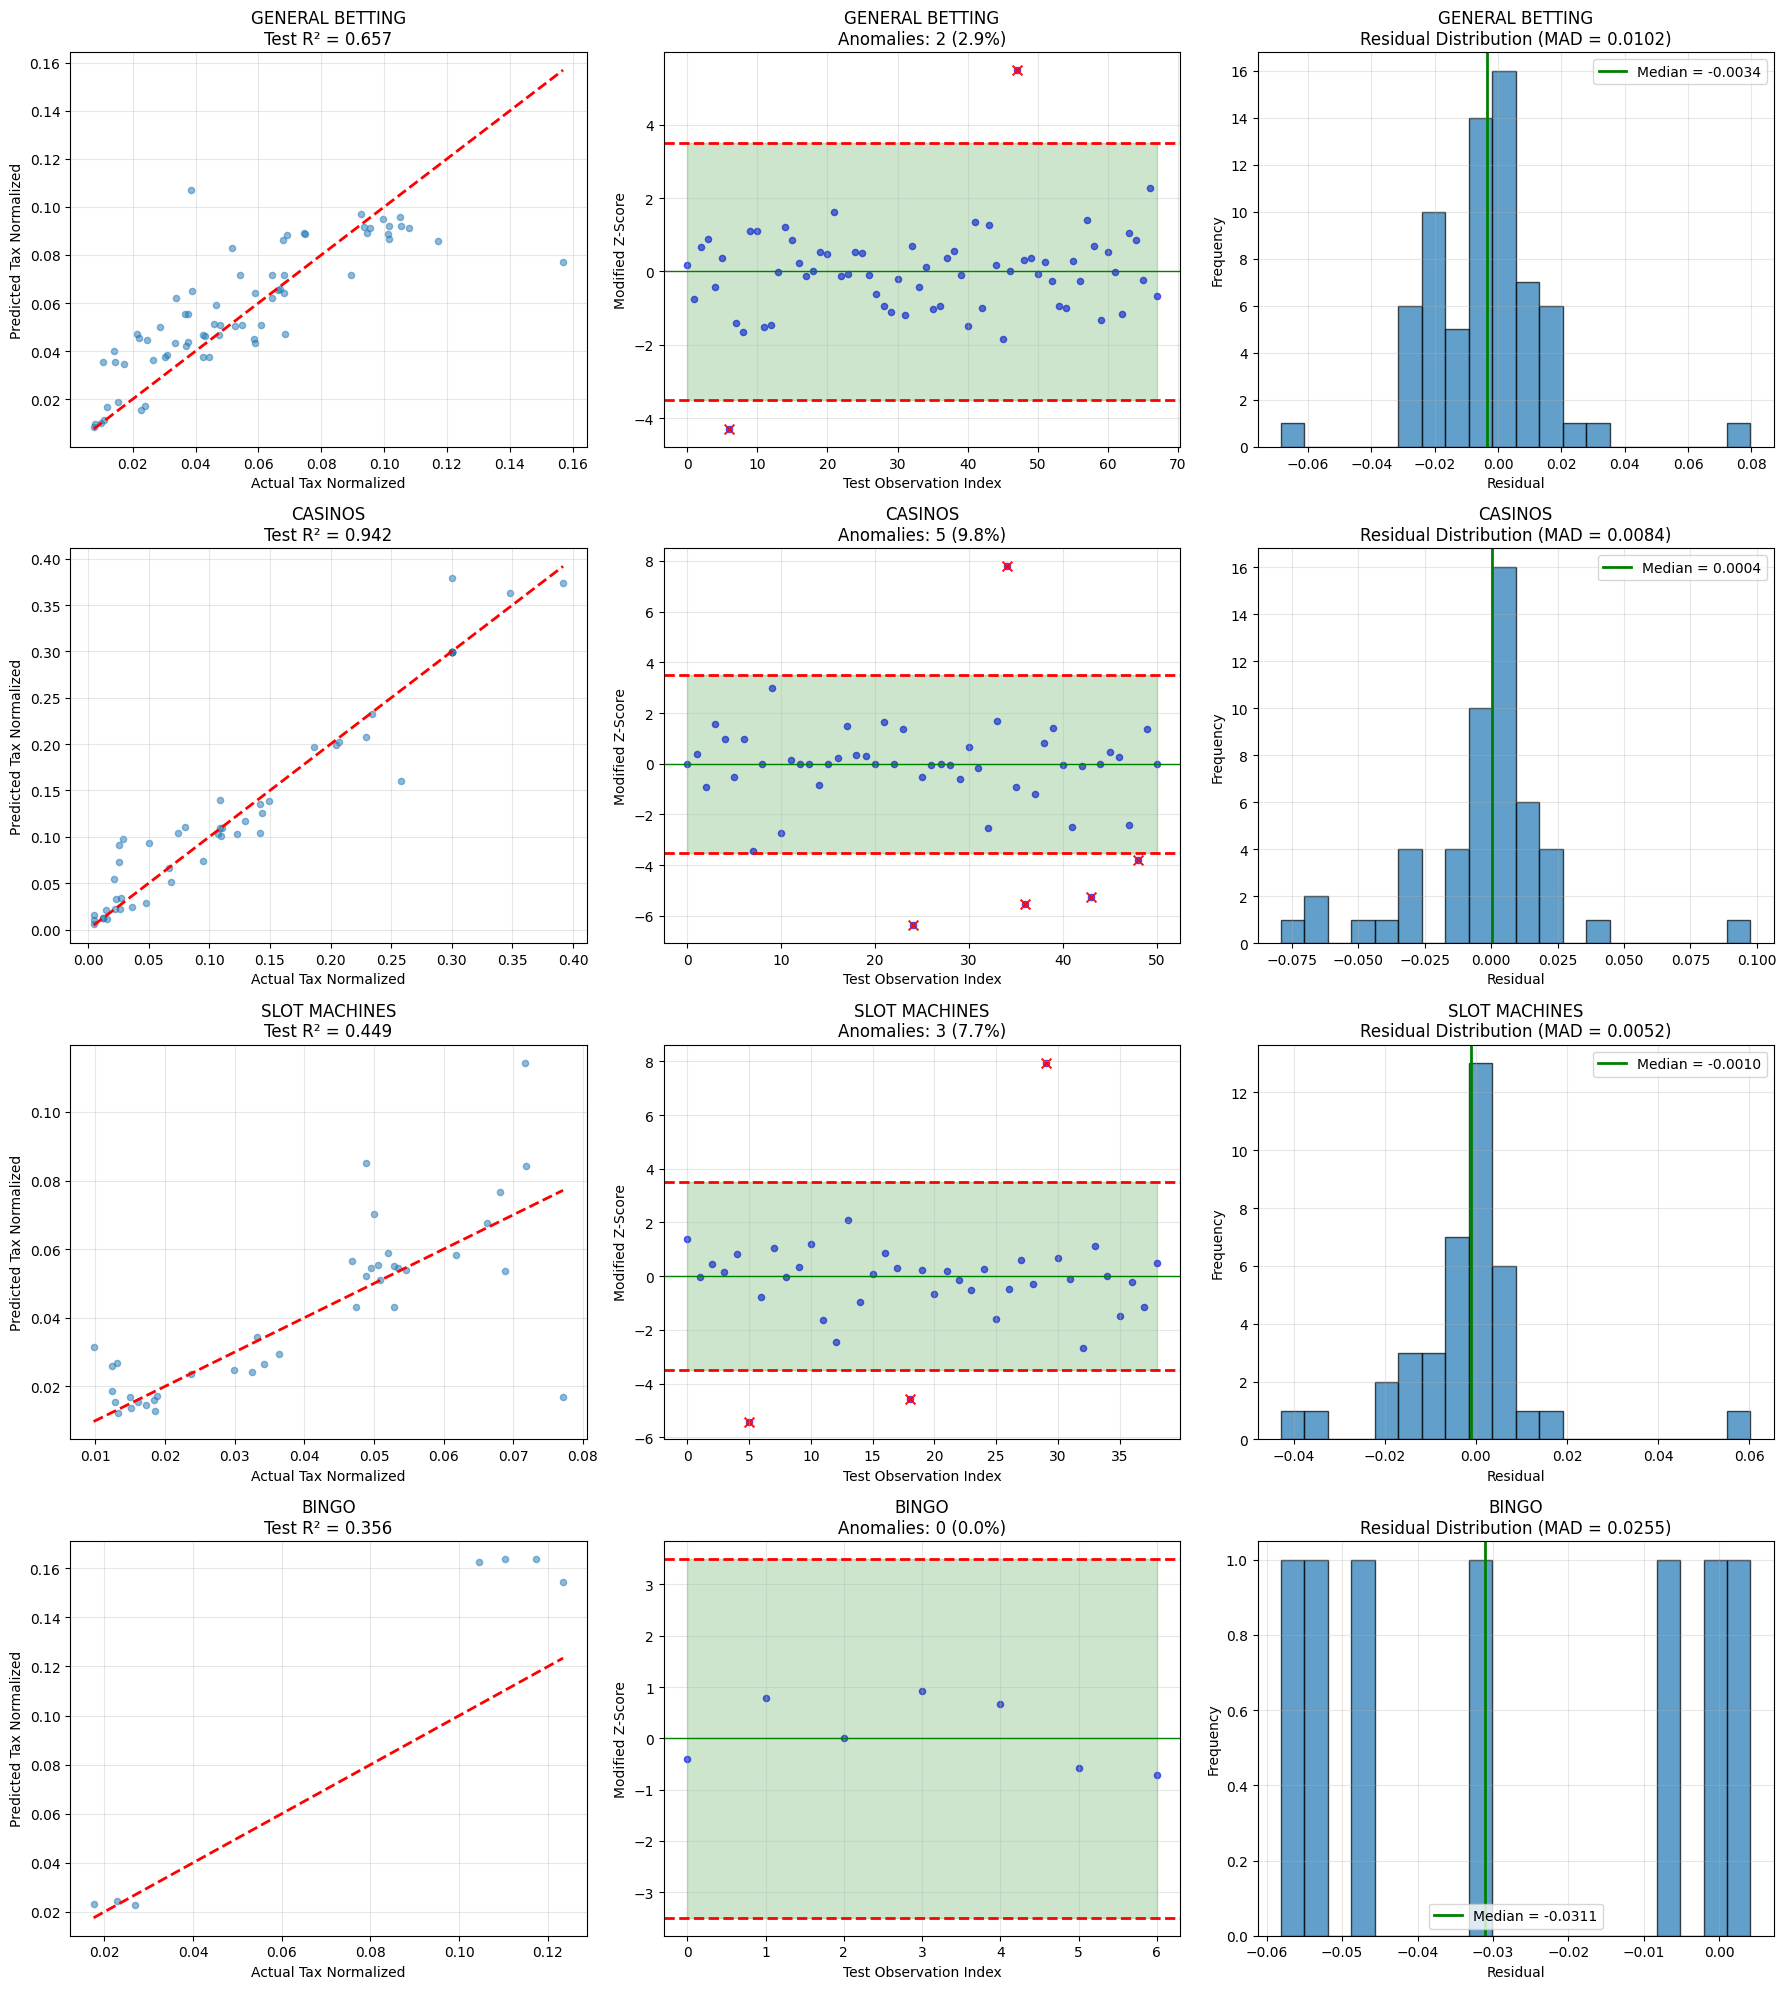

In [14]:
# Visualize results for all categories
import matplotlib.pyplot as plt

n_categories = len(category_models)
if n_categories > 0:
    fig, axes = plt.subplots(n_categories, 3, figsize=(18, 5*n_categories))
    
    # Handle case of single category
    if n_categories == 1:
        axes = axes.reshape(1, -1)
    
    for idx, (category, data) in enumerate(category_models.items()):
        # 1. Actual vs Predicted
        axes[idx, 0].scatter(data['y_test'], data['y_pred_test'], alpha=0.5, s=20)
        axes[idx, 0].plot([data['y_test'].min(), data['y_test'].max()], 
                         [data['y_test'].min(), data['y_test'].max()], 'r--', lw=2)
        axes[idx, 0].set_xlabel('Actual Tax Normalized')
        axes[idx, 0].set_ylabel('Predicted Tax Normalized')
        axes[idx, 0].set_title(f'{category}\nTest R² = {r2_score(data["y_test"], data["y_pred_test"]):.3f}')
        axes[idx, 0].grid(True, alpha=0.3)
        
        # 2. Modified Z-Scores
        axes[idx, 1].scatter(range(len(data['modified_z_test'])), data['modified_z_test'], 
                            alpha=0.6, s=20, c='blue')
        axes[idx, 1].scatter(np.where(data['is_anomaly_test'])[0], 
                            data['modified_z_test'][data['is_anomaly_test']], 
                            alpha=0.9, s=50, color='red', marker='x')
        axes[idx, 1].axhline(y=Z_THRESHOLD, color='red', linestyle='--', linewidth=2)
        axes[idx, 1].axhline(y=-Z_THRESHOLD, color='red', linestyle='--', linewidth=2)
        axes[idx, 1].axhline(y=0, color='green', linestyle='-', linewidth=1)
        axes[idx, 1].fill_between(range(len(data['modified_z_test'])), 
                                  -Z_THRESHOLD, Z_THRESHOLD, alpha=0.2, color='green')
        axes[idx, 1].set_xlabel('Test Observation Index')
        axes[idx, 1].set_ylabel('Modified Z-Score')
        axes[idx, 1].set_title(f'{category}\nAnomalies: {data["is_anomaly_test"].sum()} ({100*data["is_anomaly_test"].sum()/len(data["is_anomaly_test"]):.1f}%)')
        axes[idx, 1].grid(True, alpha=0.3)
        
        # 3. Residual distribution
        axes[idx, 2].hist(data['residuals_test'], bins=20, edgecolor='black', alpha=0.7)
        axes[idx, 2].axvline(x=data['median_resid'], color='green', linestyle='-', 
                            linewidth=2, label=f'Median = {data["median_resid"]:.4f}')
        axes[idx, 2].set_xlabel('Residual')
        axes[idx, 2].set_ylabel('Frequency')
        axes[idx, 2].set_title(f'{category}\nResidual Distribution (MAD = {data["mad_resid"]:.4f})')
        axes[idx, 2].legend()
        axes[idx, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No models to visualize")

In [13]:
# Summary table of all models
summary_df = pd.DataFrame(category_results)
summary_df = summary_df.sort_values('Test_R2', ascending=False)

print("\nModel Performance by Category")
print("="*80)
print(summary_df.to_string(index=False))

print(f"\n\n✓ Built {len(category_models)} category-specific models")
print(f"✓ Each model uses Random Forest with lag features (AR approach)")
print(f"✓ Modified Z-scores computed GLOBALLY within each category")
print(f"✓ Threshold: {Z_THRESHOLD} (user-tunable)")


Model Performance by Category
       Category  N_Observations  N_Train  N_Test  Train_R2  Test_R2  Test_RMSE  N_Anomalies  Pct_Anomalies
        CASINOS             168      117      51  0.991616 0.941816   0.027348            5       9.803922
GENERAL BETTING             225      157      68  0.900601 0.656618   0.018799            2       2.941176
  SLOT MACHINES             127       88      39  0.911464 0.449141   0.015283            3       7.692308
          BINGO              21       14       7  0.954958 0.355602   0.036624            0       0.000000


✓ Built 4 category-specific models
✓ Each model uses Random Forest with lag features (AR approach)
✓ Modified Z-scores computed GLOBALLY within each category
✓ Threshold: 3.5 (user-tunable)


In [ ]:
# Build models for ALL operator categories
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

print("Building Category-Specific Models")
print("="*80)

# Get all categories
categories = df['Operator Category'].value_counts()
print(f"\nOperator Categories found: {len(categories)}")
print(categories)

# Store results for each category
category_models = {}
category_results = []

Z_THRESHOLD = 3.5  # User-tunable threshold

for category in categories.index:
    print(f"\n\n{'='*80}")
    print(f"CATEGORY: {category}")
    print('='*80)
    
    # Filter data for this category
    category_df = df[df['Operator Category'] == category].copy()
    category_df = category_df.dropna(subset=['Gaming Tax', 'Total Sales'])
    
    # Create normalized tax
    category_df['Tax Normalized'] = category_df['Gaming Tax'] / category_df['Total Sales']
    
    # Check if we have enough data
    if len(category_df) < 20:
        print(f"⚠️  Insufficient data: {len(category_df)} rows (need at least 20)")
        print(f"   Skipping {category}")
        continue
    
    # Sort by operator and date if date column exists
    if 'Date' in category_df.columns:
        category_df = category_df.sort_values(['Operator Name', 'Date'])
        category_df['Date'] = pd.to_datetime(category_df['Date'], errors='coerce')
        
        # Create month-year identifier for monthly aggregation
        category_df['YearMonth'] = category_df['Date'].dt.to_period('M')
        
        # Aggregate to monthly level per operator - AVERAGE within each month
        category_df = category_df.groupby(['Operator Name', 'YearMonth']).agg({
            'Gaming Tax': 'mean',
            'Total Sales': 'mean',
            'Total Payouts': 'mean' if 'Total Payouts' in category_df.columns else 'first',
            'Date': 'first',
            'Operator Category': 'first'
        }).reset_index()
        
        # Recalculate Tax Normalized from averaged values
        category_df['Tax Normalized'] = category_df['Gaming Tax'] / category_df['Total Sales']
        
        # Sort by operator and month
        category_df = category_df.sort_values(['Operator Name', 'YearMonth'])
        
        # Create monthly lag features (lag1 = previous month, lag2 = 2 months ago, etc.)
        category_df['tax_norm_lag1'] = category_df.groupby('Operator Name')['Tax Normalized'].shift(1)
        category_df['tax_norm_lag2'] = category_df.groupby('Operator Name')['Tax Normalized'].shift(2)
        category_df['tax_norm_lag3'] = category_df.groupby('Operator Name')['Tax Normalized'].shift(3)
    else:
        category_df = category_df.sort_values('Operator Name')
        # Create lag features (AR model) - fallback for no date
        category_df['tax_norm_lag1'] = category_df.groupby('Operator Name')['Tax Normalized'].shift(1)
        category_df['tax_norm_lag2'] = category_df.groupby('Operator Name')['Tax Normalized'].shift(2)
        category_df['tax_norm_lag3'] = category_df.groupby('Operator Name')['Tax Normalized'].shift(3)
    
    # Drop NaN from lag features AND target variable
    ar_data = category_df.dropna(subset=['tax_norm_lag1', 'tax_norm_lag2', 'tax_norm_lag3', 'Tax Normalized'])
    
    if len(ar_data) < 20:
        print(f"⚠️  Insufficient data after creating lags: {len(ar_data)} rows")
        print(f"   Skipping {category}")
        continue
    
    # Prepare features and target
    X = ar_data[['tax_norm_lag1', 'tax_norm_lag2', 'tax_norm_lag3']]
    y = ar_data['Tax Normalized']
    
    # Double-check for any remaining NaN values
    if X.isna().any().any() or y.isna().any():
        print(f"⚠️  NaN values still present after dropna")
        print(f"   Skipping {category}")
        continue
    
    # Train-test split (stratified by operator)
    try:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42, 
            stratify=ar_data['Operator Name']
        )
    except ValueError:
        # If stratification fails, do regular split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42
        )
        print("   (Using non-stratified split)")
    
    # Train Random Forest model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
    rf_model.fit(X_train, y_train)
    
    # Predictions
    y_pred_train = rf_model.predict(X_train)
    y_pred_test = rf_model.predict(X_test)
    
    # Calculate residuals
    residuals_train = y_train - y_pred_train
    residuals_test = y_test - y_pred_test
    
    # Calculate GLOBAL Modified Z-Scores (across all residuals in this category)
    median_resid = np.median(residuals_test)
    mad_resid = np.median(np.abs(residuals_test - median_resid))
    
    if mad_resid == 0:
        print(f"⚠️  MAD = 0 (no variation in residuals)")
        modified_z_test = np.zeros(len(residuals_test))
    else:
        modified_z_test = 0.6745 * (residuals_test - median_resid) / mad_resid
    
    # Flag anomalies
    is_anomaly_test = np.abs(modified_z_test) > Z_THRESHOLD
    
    # Store results
    category_models[category] = {
        'model': rf_model,
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'y_pred_train': y_pred_train,
        'y_pred_test': y_pred_test,
        'residuals_train': residuals_train,
        'residuals_test': residuals_test,
        'modified_z_test': modified_z_test,
        'is_anomaly_test': is_anomaly_test,
        'median_resid': median_resid,
        'mad_resid': mad_resid
    }
    
    # Print summary
    print(f"\nData:")
    print(f"  Total rows: {len(category_df)}")
    print(f"  After lags: {len(ar_data)}")
    print(f"  Train: {len(X_train)}, Test: {len(X_test)}")
    
    print(f"\nModel Performance:")
    print(f"  Train R²: {r2_score(y_train, y_pred_train):.4f}")
    print(f"  Test R²: {r2_score(y_test, y_pred_test):.4f}")
    print(f"  Test MAE: {mean_absolute_error(y_test, y_pred_test):.6f}")
    print(f"  Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.6f}")
    
    print(f"\nAnomaly Detection (Modified Z-Score, Threshold = {Z_THRESHOLD}):")
    print(f"  Anomalies: {is_anomaly_test.sum()} / {len(residuals_test)} ({100*is_anomaly_test.sum()/len(residuals_test):.1f}%)")
    
    # Store for summary table
    category_results.append({
        'Category': category,
        'N_Observations': len(ar_data),
        'N_Train': len(X_train),
        'N_Test': len(X_test),
        'Train_R2': r2_score(y_train, y_pred_train),
        'Test_R2': r2_score(y_test, y_pred_test),
        'Test_RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'N_Anomalies': is_anomaly_test.sum(),
        'Pct_Anomalies': 100*is_anomaly_test.sum()/len(residuals_test)
    })


print(f"\n\n{'='*80}")print('='*80)
print(f"SUMMARY: Models Built for {len(category_models)} Categories")

Building Category-Specific Models

Operator Categories found: 4
Operator Category
GENERAL BETTING    353
CASINOS            255
SLOT MACHINES      183
BINGO               28
Name: count, dtype: int64


CATEGORY: GENERAL BETTING

Data:
  Total rows: 315
  After lags: 219
  Train: 153, Test: 66

Model Performance:
  Train R²: 0.9089
  Test R²: 0.4264
  Test MAE: 0.014420
  Test RMSE: 0.024643

Anomaly Detection (Modified Z-Score, Threshold = 3.5):
  Anomalies: 4 / 66 (6.1%)


CATEGORY: CASINOS

Data:
  Total rows: 241
  After lags: 168
  Train: 117, Test: 51

Model Performance:
  Train R²: 0.9916
  Test R²: 0.9418
  Test MAE: 0.016581
  Test RMSE: 0.027348

Anomaly Detection (Modified Z-Score, Threshold = 3.5):
  Anomalies: 5 / 51 (9.8%)


CATEGORY: SLOT MACHINES

Data:
  Total rows: 180
  After lags: 127
  Train: 88, Test: 39

Model Performance:
  Train R²: 0.9115
  Test R²: 0.4491
  Test MAE: 0.009047
  Test RMSE: 0.015283

Anomaly Detection (Modified Z-Score, Threshold = 3.5):
  Anoma

## Extend to All Operator Categories

Build separate models for each category as requested by LGRB.

In [ ]:
# Current approach: GLOBAL Modified Z-Score
print("Modified Z-Score Calculation Approach")
print("="*80)

print("\n🌍 GLOBAL APPROACH (Current Implementation):")
print("-"*80)
print("  Modified Z = 0.6745 * (residual - GLOBAL_median) / GLOBAL_MAD")
print("  • Median & MAD computed across ALL operators")
print("  • Compares each operator to the overall distribution")
print("  • Best for: Identifying operators that deviate from typical behavior")
print("\n  Example:")
print("    - Global median residual = 0.001")
print("    - Operator A residual = 0.08 → Large positive Z-score → Anomaly")
print("    - All operators compared to same baseline")

print("\n\n👤 PER-OPERATOR APPROACH (Alternative):")
print("-"*80)
print("  Modified Z = 0.6745 * (residual - operator_median) / operator_MAD")
print("  • Median & MAD computed WITHIN each operator")
print("  • Compares operator's submission to their own history")
print("  • Best for: Detecting when an operator changes their behavior")
print("\n  Example:")
print("    - Operator A usually has residual ~0.05")
print("    - New submission has residual = 0.08 → Small Z-score → Normal")
print("    - But same 0.08 might be anomalous for Operator B")

print("\n\n❓ Which to use?")
print("-"*80)
print("  GLOBAL: 'Is this operator behaving differently than others?'")
print("  PER-OPERATOR: 'Is this operator behaving differently than usual?'")
print("\n  Recommendation: Use GLOBAL for cross-operator comparison ✓")

## Important: Global vs Per-Operator Modified Z-Score

Currently using GLOBAL median/MAD - compare all residuals to overall distribution.

In [ ]:
# Compare different threshold values
print("\nThreshold Sensitivity Analysis")
print("="*80)
print("Adjust Z_THRESHOLD to control anomaly detection sensitivity:\n")

thresholds_to_test = [2.5, 3.0, 3.5, 4.0, 5.0]
comparison_results = []

for thresh in thresholds_to_test:
    result = detect_anomalies_modified_zscore(residuals, threshold=thresh)
    comparison_results.append({
        'Threshold': thresh,
        'Anomalies': result['n_anomalies'],
        'Percentage': f"{result['pct_anomalies']:.1f}%",
        'Sensitivity': ['Aggressive', 'Moderate', 'Balanced', 'Conservative', 'Very Conservative'][thresholds_to_test.index(thresh)]
    })

comparison_df = pd.DataFrame(comparison_results)
print(comparison_df.to_string(index=False))

print("\n\nRecommended Thresholds:")
print("-"*80)
print("  2.5: AGGRESSIVE - Flags ~5-10% (use for high-risk operators)")
print("  3.5: BALANCED   - Flags ~1-5% (recommended for most cases) ✓")
print("  5.0: CONSERVATIVE - Flags ~0.5-2% (use when investigation capacity is limited)")

print(f"\n\n💡 To change threshold, modify the Z_THRESHOLD variable:")
print(f"   Z_THRESHOLD = 3.5  # Current value")
print(f"   Then re-run the cells to see updated results")

In [ ]:
# Visualize with the user-defined threshold
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Modified Z-Scores with threshold
axes[0, 0].scatter(range(len(results['modified_z_scores'])), results['modified_z_scores'], 
                   alpha=0.6, s=30, c='blue', label='Normal')
axes[0, 0].scatter(results['anomaly_indices'], results['modified_z_scores'][results['anomaly_indices']], 
                   alpha=0.9, s=80, color='red', marker='x', label='Anomaly')
axes[0, 0].axhline(y=Z_THRESHOLD, color='red', linestyle='--', linewidth=2, label=f'Threshold = ±{Z_THRESHOLD}')
axes[0, 0].axhline(y=-Z_THRESHOLD, color='red', linestyle='--', linewidth=2)
axes[0, 0].axhline(y=0, color='green', linestyle='-', linewidth=1)
axes[0, 0].fill_between(range(len(results['modified_z_scores'])), 
                        -Z_THRESHOLD, Z_THRESHOLD, alpha=0.2, color='green', label='Normal Range')
axes[0, 0].set_xlabel('Observation Index')
axes[0, 0].set_ylabel('Modified Z-Score')
axes[0, 0].set_title(f'Modified Z-Score Anomaly Detection (Threshold = {Z_THRESHOLD})')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Distribution of Modified Z-Scores
axes[0, 1].hist(results['modified_z_scores'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 1].axvline(x=Z_THRESHOLD, color='red', linestyle='--', linewidth=2, label=f'Threshold = ±{Z_THRESHOLD}')
axes[0, 1].axvline(x=-Z_THRESHOLD, color='red', linestyle='--', linewidth=2)
axes[0, 1].axvline(x=0, color='green', linestyle='-', linewidth=2, label='Median')
axes[0, 1].set_xlabel('Modified Z-Score')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Modified Z-Scores')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Actual vs Predicted with anomalies highlighted
normal_mask = ~results['is_anomaly']
axes[1, 0].scatter(y_test[normal_mask], y_pred_test_rf[normal_mask], 
                   alpha=0.5, s=20, color='blue', label='Normal')
axes[1, 0].scatter(y_test[results['is_anomaly']], y_pred_test_rf[results['is_anomaly']], 
                   alpha=0.9, s=80, color='red', marker='x', label=f'Anomaly ({results["n_anomalies"]})')
axes[1, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'g--', lw=2, label='Perfect Prediction')
axes[1, 0].set_xlabel('Actual Tax Normalized')
axes[1, 0].set_ylabel('Predicted Tax Normalized')
axes[1, 0].set_title(f'Anomalies Detected (Modified Z > {Z_THRESHOLD})')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Residuals with anomalies highlighted
axes[1, 1].scatter(range(len(residuals)), residuals, alpha=0.5, s=20, color='blue', label='Normal')
axes[1, 1].scatter(results['anomaly_indices'], residuals.iloc[results['anomaly_indices']], 
                   alpha=0.9, s=80, color='red', marker='x', label=f'Anomaly ({results["n_anomalies"]})')
axes[1, 1].axhline(y=0, color='green', linestyle='-', linewidth=2, label='Zero Residual')
axes[1, 1].set_xlabel('Observation Index')
axes[1, 1].set_ylabel('Residual (Actual - Predicted)')
axes[1, 1].set_title('Residuals with Anomalies Flagged')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Modified Z-Score threshold is user-tunable")
print(f"✓ Current setting: {Z_THRESHOLD} (adjust Z_THRESHOLD variable to change)")

In [ ]:
# Show which specific observations are anomalies
anomaly_report = pd.DataFrame({
    'Observation_Index': results['anomaly_indices'],
    'Actual_Tax_Normalized': y_test.iloc[results['anomaly_indices']].values,
    'Predicted_Tax_Normalized': y_pred_test_rf[results['anomaly_indices']],
    'Residual': residuals.iloc[results['anomaly_indices']].values,
    'Modified_Z_Score': results['modified_z_scores'][results['anomaly_indices']],
    'Deviation_Pct': 100 * (residuals.iloc[results['anomaly_indices']] / y_pred_test_rf[results['anomaly_indices']])
})

# Sort by absolute Modified Z-Score (most extreme first)
anomaly_report['Abs_Modified_Z'] = anomaly_report['Modified_Z_Score'].abs()
anomaly_report = anomaly_report.sort_values('Abs_Modified_Z', ascending=False)

print(f"\nTop 10 Anomalies (Threshold = {Z_THRESHOLD})")
print("="*80)
print(anomaly_report.drop('Abs_Modified_Z', axis=1).head(10).to_string(index=False))

print(f"\n\nInterpretation:")
print(f"  • Modified Z > {Z_THRESHOLD}: Tax significantly HIGHER than expected")
print(f"  • Modified Z < -{Z_THRESHOLD}: Tax significantly LOWER than expected")
print(f"  • |Modified Z| ≤ {Z_THRESHOLD}: Within normal range")

In [ ]:
def detect_anomalies_modified_zscore(residuals, threshold=3.5):
    """
    Detect anomalies using Modified Z-Score (Iglewicz & Hoaglin method).
    
    Modified Z-Score uses Median Absolute Deviation (MAD) instead of standard deviation,
    making it robust to outliers and not requiring normal distribution assumption.
    
    Parameters:
    -----------
    residuals : array-like
        Residuals from model (actual - predicted)
    threshold : float, default=3.5
        Modified Z-score threshold for anomaly detection
        - 3.5: Moderate (recommended, ~1-5% flagged)
        - 5.0: Conservative (strict, ~0.5-2% flagged)
        - 2.5: Aggressive (liberal, ~5-10% flagged)
    
    Returns:
    --------
    dict with:
        - 'modified_z_scores': Modified Z-score for each observation
        - 'is_anomaly': Boolean mask of anomalies
        - 'anomaly_indices': Indices of anomalous observations
        - 'threshold': Threshold used
        - 'n_anomalies': Number of anomalies detected
        - 'pct_anomalies': Percentage of anomalies
    """
    # Calculate MAD (Median Absolute Deviation)
    median = np.median(residuals)
    mad = np.median(np.abs(residuals - median))
    
    # Modified Z-score formula (Iglewicz & Hoaglin, 1993)
    # 0.6745 is the constant to make MAD consistent with std for normal distribution
    modified_z_scores = 0.6745 * (residuals - median) / mad
    
    # Flag anomalies
    is_anomaly = np.abs(modified_z_scores) > threshold
    anomaly_indices = np.where(is_anomaly)[0]
    
    return {
        'modified_z_scores': modified_z_scores,
        'is_anomaly': is_anomaly,
        'anomaly_indices': anomaly_indices,
        'threshold': threshold,
        'n_anomalies': is_anomaly.sum(),
        'pct_anomalies': 100 * is_anomaly.sum() / len(residuals),
        'median': median,
        'mad': mad
    }

# Example usage with default threshold
print("Modified Z-Score Anomaly Detection")
print("="*80)
print("\nMethod: MAD-based Modified Z-Score (Iglewicz & Hoaglin)")
print("  ✓ Robust to outliers")
print("  ✓ No normal distribution assumption")
print("  ✓ Distribution-free")

# You can adjust the threshold here
Z_THRESHOLD = 3.5  # User-tunable parameter

results = detect_anomalies_modified_zscore(residuals, threshold=Z_THRESHOLD)

print(f"\nConfiguration:")
print(f"  Modified Z-Score Threshold: {results['threshold']}")
print(f"  Residual Median: {results['median']:.6f}")
print(f"  MAD (Median Absolute Deviation): {results['mad']:.6f}")

print(f"\nResults:")
print(f"  Total observations: {len(residuals)}")
print(f"  Anomalies detected: {results['n_anomalies']} ({results['pct_anomalies']:.1f}%)")
print(f"  Normal observations: {len(residuals) - results['n_anomalies']} ({100 - results['pct_anomalies']:.1f}%)")

## Final Recommendation: Modified Z-Score with User-Tunable Threshold

Use MAD-based Modified Z-score for robust, distribution-free anomaly detection.

In [3]:
# Compare all methods side by side
comparison = pd.DataFrame({
    'Method': [
        'Z-score |Z| > 2 (assumes normal)',
        'Z-score |Z| > 3 (assumes normal)',
        'Empirical 2.5%-97.5%',
        'Empirical 0.15%-99.85%',
        'Modified Z-score > 3.5',
        'Modified Z-score > 5'
    ],
    'Anomalies': [
        anomalies_zscore_2.sum(),
        anomalies_zscore_3.sum(),
        anomalies_empirical_95.sum(),
        anomalies_empirical_997.sum(),
        anomalies_mad_moderate.sum(),
        anomalies_mad_strict.sum()
    ],
    'Percentage': [
        f"{100*anomalies_zscore_2.sum()/len(residuals):.1f}%",
        f"{100*anomalies_zscore_3.sum()/len(residuals):.1f}%",
        f"{100*anomalies_empirical_95.sum()/len(residuals):.1f}%",
        f"{100*anomalies_empirical_997.sum()/len(residuals):.1f}%",
        f"{100*anomalies_mad_moderate.sum()/len(residuals):.1f}%",
        f"{100*anomalies_mad_strict.sum()/len(residuals):.1f}%"
    ],
    'Assumes Normal?': [
        'Yes',
        'Yes',
        'No',
        'No',
        'No',
        'No'
    ]
})

print("\n" + "="*80)
print("METHOD COMPARISON")
print("="*80)
print(comparison.to_string(index=False))

print("\n\n✅ RECOMMENDATION:")
print("-"*80)
if p_value_normality > 0.05 and abs(within_2sd - 95) < 5:
    print("Your residuals ARE approximately normal:")
    print("  → Use Z-score |Z| > 2 (or 3 for stricter)")
    print("  → Interpretation: Beyond 95% (or 99.7%) of expected range")
else:
    print("Your residuals are NOT perfectly normal:")
    print("  → Option A: Use Empirical Percentiles (e.g., 2.5%-97.5%)")
    print("  → Option B: Use Modified Z-score > 3.5")
    print("  → Both are distribution-free and robust")
    print("\n  If you still want to use Z-score:")
    print("  → Use it, but DON'T claim '95% of normal range'")
    print("  → Instead say: 'Z-score threshold of 2' (descriptive, not probabilistic)")

NameError: name 'pd' is not defined

In [2]:
# So what should we use if residuals aren't perfectly normal?
print("\n" + "="*80)
print("SOLUTIONS FOR NON-NORMAL DISTRIBUTIONS")
print("="*80)

print("\n📊 OPTION 1: Empirical Percentiles (Distribution-Free)")
print("-"*80)
print("  Instead of assuming 95%, use ACTUAL percentiles from your data")

# Calculate empirical thresholds
p2_5 = np.percentile(residuals, 2.5)
p97_5 = np.percentile(residuals, 97.5)
p0_15 = np.percentile(residuals, 0.15)
p99_85 = np.percentile(residuals, 99.85)

anomalies_empirical_95 = (residuals < p2_5) | (residuals > p97_5)
anomalies_empirical_997 = (residuals < p0_15) | (residuals > p99_85)

print(f"\n  2.5% - 97.5% (analogous to ±2 SD):")
print(f"    Thresholds: [{p2_5:.6f}, {p97_5:.6f}]")
print(f"    Anomalies: {anomalies_empirical_95.sum()} ({100*anomalies_empirical_95.sum()/len(residuals):.1f}%)")
print(f"\n  0.15% - 99.85% (analogous to ±3 SD):")
print(f"    Thresholds: [{p0_15:.6f}, {p99_85:.6f}]")
print(f"    Anomalies: {anomalies_empirical_997.sum()} ({100*anomalies_empirical_997.sum()/len(residuals):.1f}%)")
print(f"\n  ✓ No normality assumption")
print(f"  ✓ Based on actual data distribution")

print("\n📊 OPTION 2: Modified Z-Score (MAD-based, Robust)")
print("-"*80)
print("  Uses Median Absolute Deviation instead of standard deviation")
print("  Robust to outliers and doesn't assume normality")

# MAD calculation (already did this)
mad = np.median(np.abs(residuals - residuals.median()))
modified_z_scores = 0.6745 * (residuals - residuals.median()) / mad

# Using threshold of 3.5 for modified Z-score (Iglewicz & Hoaglin)
anomalies_mad_moderate = np.abs(modified_z_scores) > 3.5
anomalies_mad_strict = np.abs(modified_z_scores) > 5

print(f"\n  Modified Z-score > 3.5 (moderate):")
print(f"    Anomalies: {anomalies_mad_moderate.sum()} ({100*anomalies_mad_moderate.sum()/len(residuals):.1f}%)")
print(f"\n  Modified Z-score > 5 (strict):")
print(f"    Anomalies: {anomalies_mad_strict.sum()} ({100*anomalies_mad_strict.sum()/len(residuals):.1f}%)")
print(f"\n  ✓ Robust to outliers")
print(f"  ✓ No normality assumption")

print("\n📊 OPTION 3: Use Z-Score BUT with Empirical Thresholds")
print("-"*80)
print("  Calculate Z-scores but set thresholds based on actual data")
print(f"  Z-score at 2.5th percentile: {np.percentile(z_scores, 2.5):.2f}")
print(f"  Z-score at 97.5th percentile: {np.percentile(z_scores, 97.5):.2f}")
print(f"  (If normal, would be exactly -2.0 and +2.0)")
print(f"\n  ✓ Familiar Z-score metric")
print(f"  ✓ Thresholds adapted to actual distribution")


SOLUTIONS FOR NON-NORMAL DISTRIBUTIONS

📊 OPTION 1: Empirical Percentiles (Distribution-Free)
--------------------------------------------------------------------------------
  Instead of assuming 95%, use ACTUAL percentiles from your data


NameError: name 'np' is not defined

In [1]:
# Critical Question: Does |Z| ≤ 2 assume normal distribution?
print("Z-Score and the Normality Assumption")
print("="*80)

print("\n📌 SHORT ANSWER: YES, for the probabilistic interpretation")
print("-"*80)

print("\nZ-Score = (value - mean) / std_dev")
print("  • Can be calculated for ANY distribution")
print("  • Standardizes data to mean=0, std=1")
print("  • No normality required for CALCULATION")

print("\nBUT the interpretation '95% within ±2 SD' ASSUMES NORMALITY:")
print("  • IF normal: ~95% of data within ±2 SD")
print("  • IF normal: ~99.7% of data within ±3 SD")
print("  • IF NOT normal: These percentages DON'T hold!")

print("\n" + "="*80)
print("Let's check: ARE our residuals normally distributed?")
print("="*80)

# Normality tests we already ran
from scipy import stats
_, p_value_normality = stats.normaltest(residuals)
_, p_value_shapiro = stats.shapiro(residuals)

print(f"\n1. D'Agostino-Pearson test: p-value = {p_value_normality:.4f}")
if p_value_normality > 0.05:
    print("   ✓ Residuals appear normal (p > 0.05)")
else:
    print("   ✗ Residuals NOT normal (p < 0.05)")

print(f"\n2. Shapiro-Wilk test: p-value = {p_value_shapiro:.4f}")
if p_value_shapiro > 0.05:
    print("   ✓ Residuals appear normal (p > 0.05)")
else:
    print("   ✗ Residuals NOT normal (p < 0.05)")

# Check actual percentages in our data
within_2sd = np.sum(np.abs(z_scores) <= 2) / len(z_scores) * 100
within_3sd = np.sum(np.abs(z_scores) <= 3) / len(z_scores) * 100

print(f"\n3. Empirical check:")
print(f"   In our data: {within_2sd:.1f}% within ±2 SD (normal expects 95%)")
print(f"   In our data: {within_3sd:.1f}% within ±3 SD (normal expects 99.7%)")

if abs(within_2sd - 95) < 5:
    print("   ✓ Close to normal distribution")
else:
    print(f"   ⚠️  Deviates from normal ({within_2sd:.1f}% vs expected 95%)")

Z-Score and the Normality Assumption

📌 SHORT ANSWER: YES, for the probabilistic interpretation
--------------------------------------------------------------------------------

Z-Score = (value - mean) / std_dev
  • Can be calculated for ANY distribution
  • Standardizes data to mean=0, std=1
  • No normality required for CALCULATION

BUT the interpretation '95% within ±2 SD' ASSUMES NORMALITY:
  • IF normal: ~95% of data within ±2 SD
  • IF normal: ~99.7% of data within ±3 SD
  • IF NOT normal: These percentages DON'T hold!

Let's check: ARE our residuals normally distributed?


NameError: name 'residuals' is not defined

## Important: Normality Assumption

Does Z-score require normal distribution?

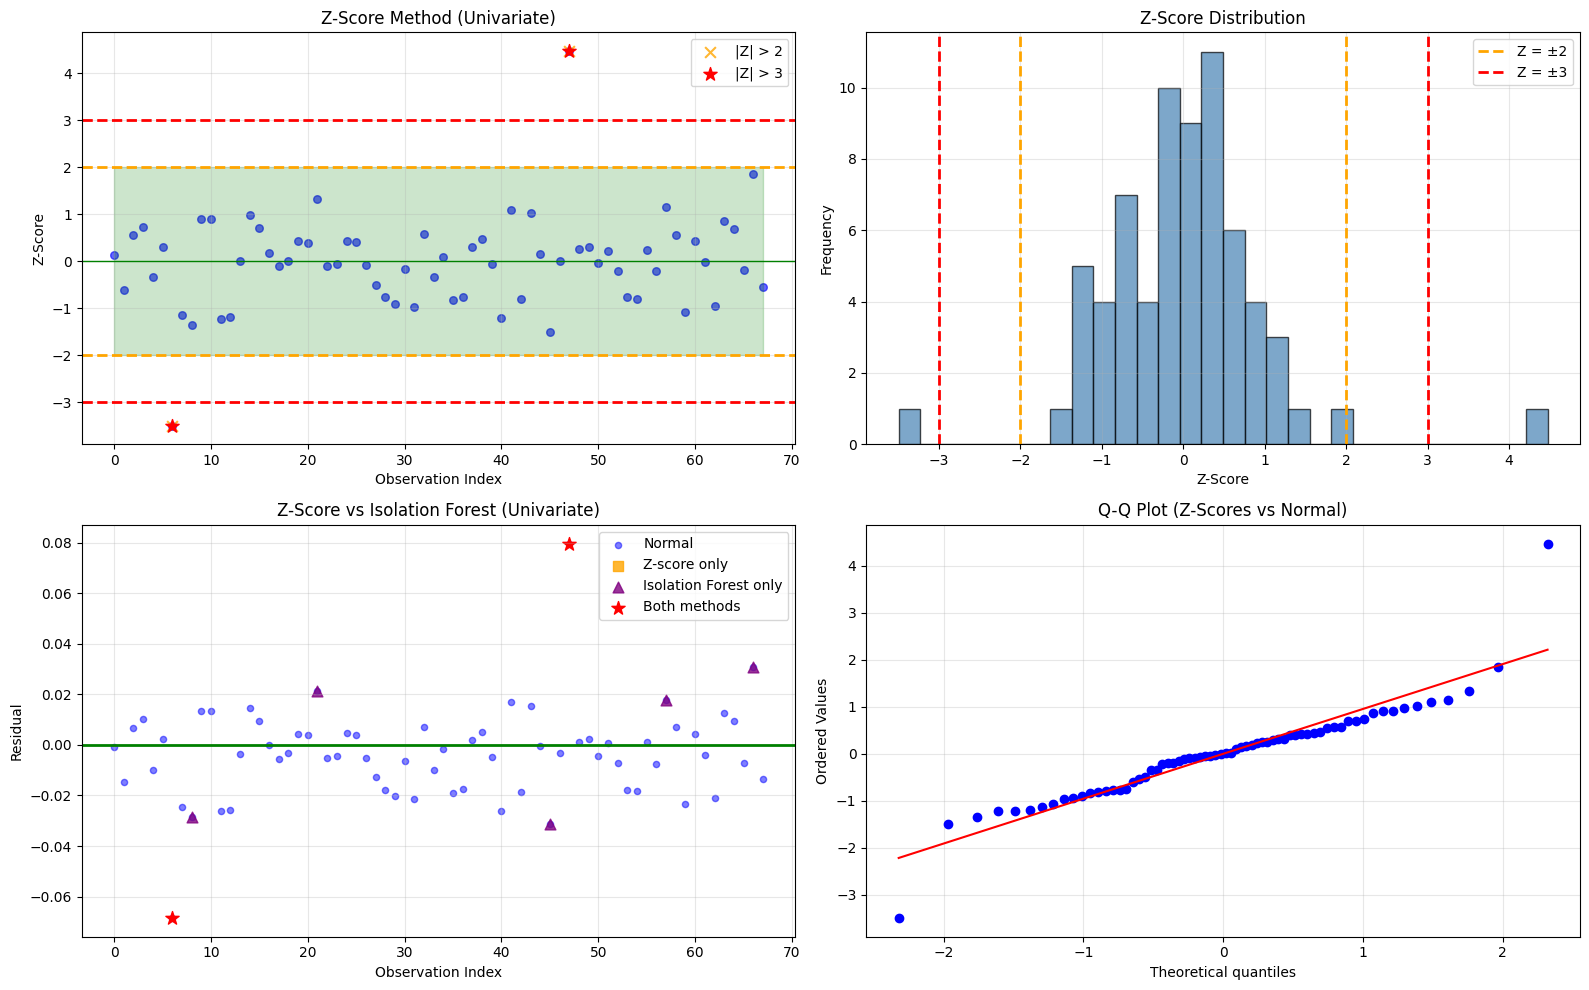


✓ Z-Score method is more appropriate for univariate residual analysis
✓ Thresholds are interpretable: |Z| > 2 = beyond 95% of normal distribution
✓ Isolation Forest useful when analyzing patterns across MULTIPLE features


In [59]:
# Visualize Z-score approach vs other methods
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Z-scores with thresholds
axes[0, 0].scatter(range(len(z_scores)), z_scores, alpha=0.6, s=30, c='blue')
axes[0, 0].scatter(np.where(anomalies_zscore_2)[0], z_scores[anomalies_zscore_2], 
                   alpha=0.8, s=60, color='orange', marker='x', label='|Z| > 2')
axes[0, 0].scatter(np.where(anomalies_zscore_3)[0], z_scores[anomalies_zscore_3], 
                   alpha=1.0, s=100, color='red', marker='*', label='|Z| > 3')
axes[0, 0].axhline(y=2, color='orange', linestyle='--', linewidth=2)
axes[0, 0].axhline(y=-2, color='orange', linestyle='--', linewidth=2)
axes[0, 0].axhline(y=3, color='red', linestyle='--', linewidth=2)
axes[0, 0].axhline(y=-3, color='red', linestyle='--', linewidth=2)
axes[0, 0].axhline(y=0, color='green', linestyle='-', linewidth=1)
axes[0, 0].fill_between(range(len(z_scores)), -2, 2, alpha=0.2, color='green')
axes[0, 0].set_xlabel('Observation Index')
axes[0, 0].set_ylabel('Z-Score')
axes[0, 0].set_title('Z-Score Method (Univariate)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Distribution of Z-scores
axes[0, 1].hist(z_scores, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 1].axvline(x=2, color='orange', linestyle='--', linewidth=2, label='Z = ±2')
axes[0, 1].axvline(x=-2, color='orange', linestyle='--', linewidth=2)
axes[0, 1].axvline(x=3, color='red', linestyle='--', linewidth=2, label='Z = ±3')
axes[0, 1].axvline(x=-3, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Z-Score')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Z-Score Distribution')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Compare Z-score vs Isolation Forest (univariate)
axes[1, 0].scatter(range(len(residuals)), residuals, alpha=0.5, s=20, color='blue', label='Normal')
z_only = anomalies_zscore_2 & ~anomalies_iso_univariate
iso_only = ~anomalies_zscore_2 & anomalies_iso_univariate
both = anomalies_zscore_2 & anomalies_iso_univariate
axes[1, 0].scatter(np.where(z_only)[0], residuals[z_only], 
                   alpha=0.8, s=60, color='orange', marker='s', label='Z-score only')
axes[1, 0].scatter(np.where(iso_only)[0], residuals[iso_only], 
                   alpha=0.8, s=60, color='purple', marker='^', label='Isolation Forest only')
axes[1, 0].scatter(np.where(both)[0], residuals[both], 
                   alpha=1.0, s=100, color='red', marker='*', label='Both methods')
axes[1, 0].axhline(y=0, color='green', linestyle='-', linewidth=2)
axes[1, 0].set_xlabel('Observation Index')
axes[1, 0].set_ylabel('Residual')
axes[1, 0].set_title('Z-Score vs Isolation Forest (Univariate)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Q-Q plot comparing residuals to normal distribution
from scipy import stats
stats.probplot(z_scores, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot (Z-Scores vs Normal)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Z-Score method is more appropriate for univariate residual analysis")
print(f"✓ Thresholds are interpretable: |Z| > 2 = beyond 95% of normal distribution")
print(f"✓ Isolation Forest useful when analyzing patterns across MULTIPLE features")

In [58]:
# Test: Does multivariate approach add value over univariate?
# Apply Isolation Forest to ONLY residuals (univariate) vs features+residuals (multivariate)

print("\nTest: Isolation Forest on Univariate vs Multivariate Data")
print("="*80)

# Univariate: Only residuals
iso_univariate = IsolationForest(contamination=0.1, random_state=42)
anomalies_iso_univariate = iso_univariate.fit_predict(residuals.values.reshape(-1, 1)) == -1

# Multivariate: Features + residuals (what we did before)
# anomalies_iso already computed

print(f"\nIsolation Forest on ONLY residuals (univariate):")
print(f"  Anomalies: {anomalies_iso_univariate.sum()} ({100*anomalies_iso_univariate.sum()/len(residuals):.1f}%)")

print(f"\nIsolation Forest on features + residuals (multivariate):")
print(f"  Anomalies: {anomalies_iso.sum()} ({100*anomalies_iso.sum()/len(residuals):.1f}%)")

print(f"\nZ-Score on residuals (univariate, |Z| > 2):")
print(f"  Anomalies: {anomalies_zscore_2.sum()} ({100*anomalies_zscore_2.sum()/len(residuals):.1f}%)")

# Check overlap
overlap_iso_uni_zscore = np.sum(anomalies_iso_univariate & anomalies_zscore_2)
overlap_iso_multi_zscore = np.sum(anomalies_iso & anomalies_zscore_2)

print(f"\nOverlap Analysis:")
print(f"  Isolation Forest (univariate) ∩ Z-score: {overlap_iso_uni_zscore} observations")
print(f"  Isolation Forest (multivariate) ∩ Z-score: {overlap_iso_multi_zscore} observations")

print(f"\n✓ Conclusion:")
print(f"  For UNIVARIATE residual analysis → Use Z-score (simple, interpretable)")
print(f"  For MULTIVARIATE pattern detection → Use Isolation Forest on features")


Test: Isolation Forest on Univariate vs Multivariate Data

Isolation Forest on ONLY residuals (univariate):
  Anomalies: 7 (10.3%)

Isolation Forest on features + residuals (multivariate):
  Anomalies: 7 (10.3%)

Z-Score on residuals (univariate, |Z| > 2):
  Anomalies: 2 (2.9%)

Overlap Analysis:
  Isolation Forest (univariate) ∩ Z-score: 2 observations
  Isolation Forest (multivariate) ∩ Z-score: 2 observations

✓ Conclusion:
  For UNIVARIATE residual analysis → Use Z-score (simple, interpretable)
  For MULTIVARIATE pattern detection → Use Isolation Forest on features


In [57]:
# Compare univariate vs multivariate approaches
print("Univariate vs Multivariate Anomaly Detection")
print("="*80)

print("\nWhat we're detecting anomalies in:")
print(f"  Univariate: Just residuals (1 dimension)")
print(f"  Multivariate: Features + residuals ({X_anomaly.shape[1]} dimensions)")

print("\n" + "="*80)
print("UNIVARIATE METHODS (for residuals only)")
print("="*80)

# 1. Z-Score (most appropriate for univariate)
z_scores = (residuals - residuals.mean()) / residuals.std()
anomalies_zscore_2 = np.abs(z_scores) > 2  # 2 standard deviations
anomalies_zscore_3 = np.abs(z_scores) > 3  # 3 standard deviations

print(f"\n1. Z-Score Method (RECOMMENDED for univariate):")
print(f"   |Z| > 2: {anomalies_zscore_2.sum()} anomalies ({100*anomalies_zscore_2.sum()/len(residuals):.1f}%)")
print(f"   |Z| > 3: {anomalies_zscore_3.sum()} anomalies ({100*anomalies_zscore_3.sum()/len(residuals):.1f}%)")
print(f"   ✓ Simple, interpretable, statistically grounded")

# 2. MAD (Median Absolute Deviation - robust to outliers)
mad = np.median(np.abs(residuals - residuals.median()))
modified_z_scores = 0.6745 * (residuals - residuals.median()) / mad
anomalies_mad = np.abs(modified_z_scores) > 3.5

print(f"\n2. Modified Z-Score (MAD-based, robust):")
print(f"   |Modified Z| > 3.5: {anomalies_mad.sum()} anomalies ({100*anomalies_mad.sum()/len(residuals):.1f}%)")
print(f"   ✓ Robust to outliers, good for non-normal distributions")

# 3. Percentile (distribution-free)
print(f"\n3. Percentile Method (distribution-free):")
print(f"   5%-95%: {anomalies_p95.sum()} anomalies ({100*anomalies_p95.sum()/len(residuals):.1f}%)")
print(f"   ✓ No distribution assumptions")

print("\n" + "="*80)
print("MULTIVARIATE METHODS (for features + residuals)")
print("="*80)

print(f"\n4. Isolation Forest on features + residuals:")
print(f"   Anomalies: {anomalies_iso.sum()} ({100*anomalies_iso.sum()/len(residuals):.1f}%)")
print(f"   ✓ Can detect complex patterns across multiple dimensions")
print(f"   ✗ Less interpretable for univariate residuals")

print(f"\n5. Local Outlier Factor on features + residuals:")
print(f"   Anomalies: {anomalies_lof.sum()} ({100*anomalies_lof.sum()/len(residuals):.1f}%)")
print(f"   ✓ Good for density-based anomalies")
print(f"   ✗ Overkill for simple univariate analysis")

Univariate vs Multivariate Anomaly Detection

What we're detecting anomalies in:
  Univariate: Just residuals (1 dimension)
  Multivariate: Features + residuals (4 dimensions)

UNIVARIATE METHODS (for residuals only)

1. Z-Score Method (RECOMMENDED for univariate):
   |Z| > 2: 2 anomalies (2.9%)
   |Z| > 3: 2 anomalies (2.9%)
   ✓ Simple, interpretable, statistically grounded

2. Modified Z-Score (MAD-based, robust):
   |Modified Z| > 3.5: 2 anomalies (2.9%)
   ✓ Robust to outliers, good for non-normal distributions

3. Percentile Method (distribution-free):
   5%-95%: 8 anomalies (11.8%)
   ✓ No distribution assumptions

MULTIVARIATE METHODS (for features + residuals)

4. Isolation Forest on features + residuals:
   Anomalies: 7 (10.3%)
   ✓ Can detect complex patterns across multiple dimensions
   ✗ Less interpretable for univariate residuals

5. Local Outlier Factor on features + residuals:
   Anomalies: 7 (10.3%)
   ✓ Good for density-based anomalies
   ✗ Overkill for simple univar

## Univariate vs Multivariate Anomaly Detection

Clarify when to use statistical methods (Z-score) vs unsupervised ML.

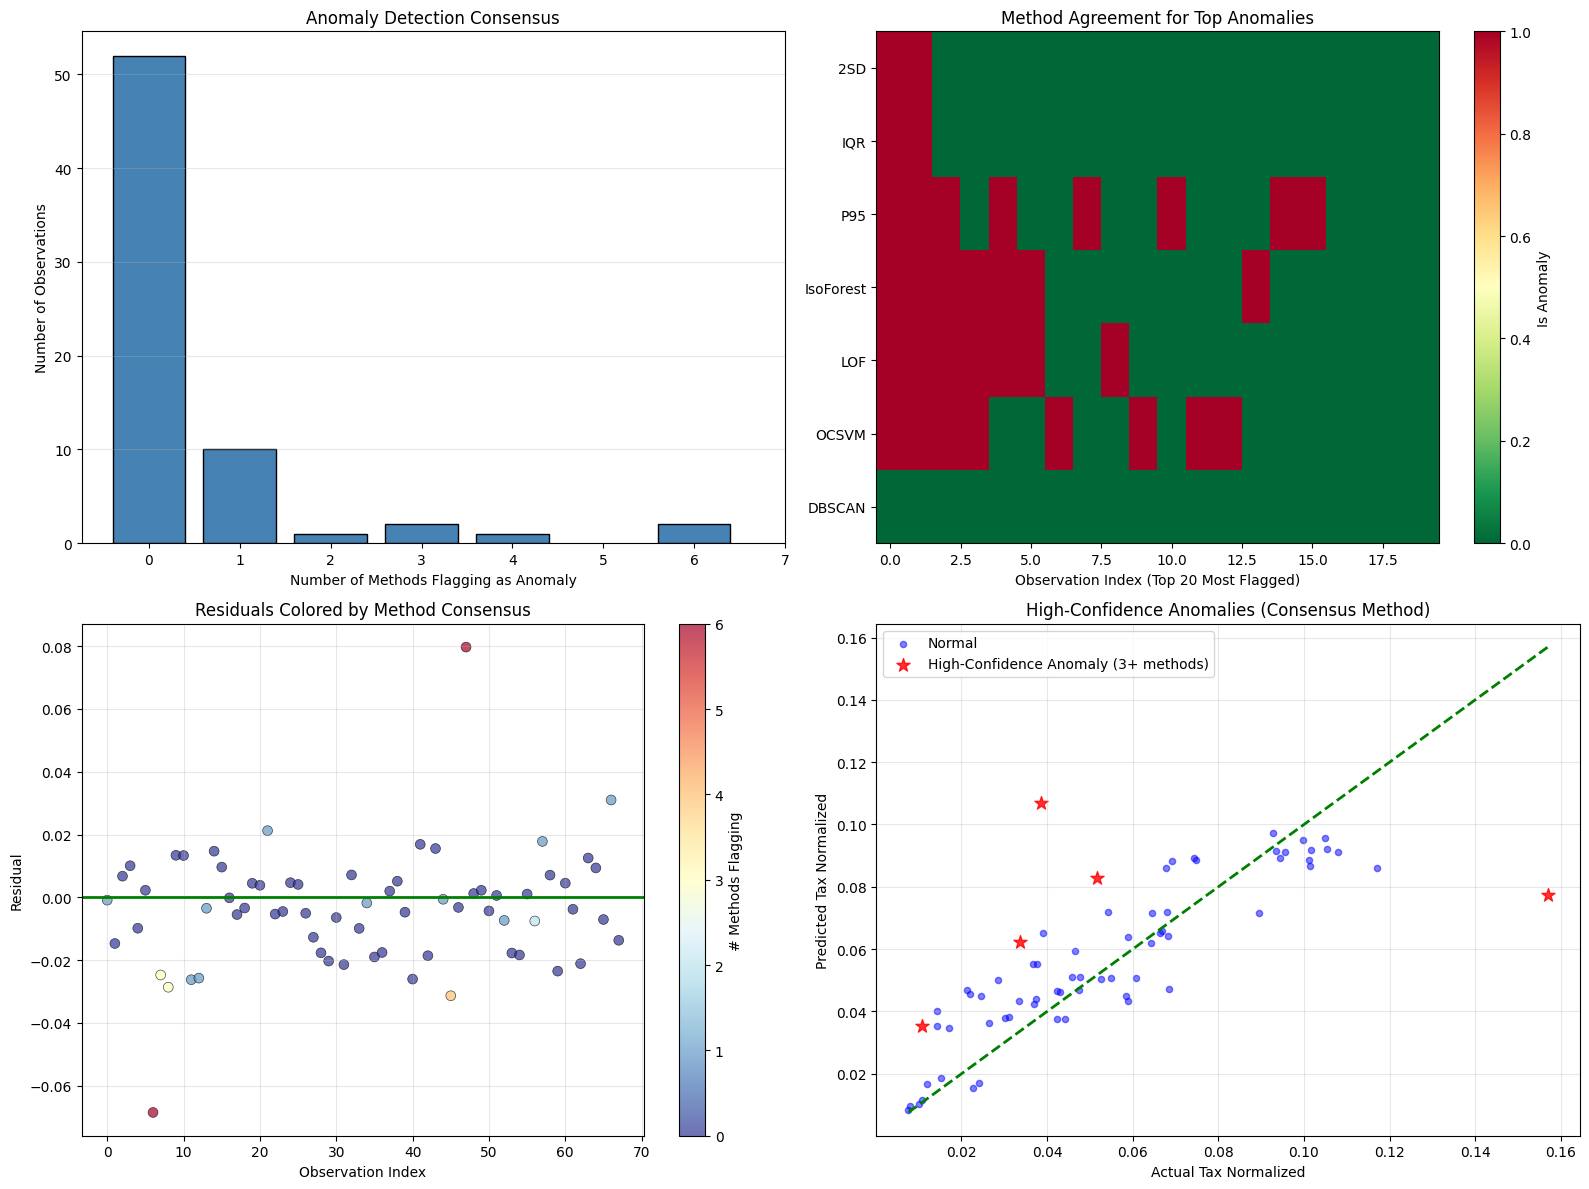

In [55]:
# Visualize method comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Venn-like visualization of anomaly overlap
method_counts = anomaly_df['total_flags'].value_counts().sort_index()
axes[0, 0].bar(method_counts.index, method_counts.values, color='steelblue', edgecolor='black')
axes[0, 0].set_xlabel('Number of Methods Flagging as Anomaly')
axes[0, 0].set_ylabel('Number of Observations')
axes[0, 0].set_title('Anomaly Detection Consensus')
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].set_xticks(range(0, 8))

# 2. Heatmap of which observations are flagged by which methods
top_flagged = anomaly_df.nlargest(20, 'total_flags').drop('total_flags', axis=1)
im = axes[0, 1].imshow(top_flagged.T, aspect='auto', cmap='RdYlGn_r', interpolation='nearest')
axes[0, 1].set_yticks(range(len(top_flagged.columns)))
axes[0, 1].set_yticklabels(top_flagged.columns)
axes[0, 1].set_xlabel('Observation Index (Top 20 Most Flagged)')
axes[0, 1].set_title('Method Agreement for Top Anomalies')
plt.colorbar(im, ax=axes[0, 1], label='Is Anomaly')

# 3. Residuals colored by consensus level
scatter = axes[1, 0].scatter(range(len(residuals)), residuals, 
                             c=anomaly_df['total_flags'], cmap='RdYlBu_r', 
                             s=50, alpha=0.7, edgecolors='black', linewidth=0.5)
axes[1, 0].axhline(y=0, color='green', linestyle='-', linewidth=2)
axes[1, 0].set_xlabel('Observation Index')
axes[1, 0].set_ylabel('Residual')
axes[1, 0].set_title('Residuals Colored by Method Consensus')
plt.colorbar(scatter, ax=axes[1, 0], label='# Methods Flagging')
axes[1, 0].grid(True, alpha=0.3)

# 4. Method comparison - actual vs predicted with high-confidence anomalies
normal_mask = ~high_confidence
axes[1, 1].scatter(y_test[normal_mask], y_pred_test_rf[normal_mask], 
                   alpha=0.5, s=20, color='blue', label='Normal')
axes[1, 1].scatter(y_test[high_confidence], y_pred_test_rf[high_confidence], 
                   alpha=0.8, s=100, color='red', marker='*', label='High-Confidence Anomaly (3+ methods)')
axes[1, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'g--', lw=2)
axes[1, 1].set_xlabel('Actual Tax Normalized')
axes[1, 1].set_ylabel('Predicted Tax Normalized')
axes[1, 1].set_title('High-Confidence Anomalies (Consensus Method)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [54]:
# Compare all anomaly detection methods
methods = {
    '±2 SD (Statistical)': anomalies_2sd,
    'IQR (Statistical)': anomalies_iqr,
    '5%-95% Percentile': anomalies_p95,
    'Isolation Forest': anomalies_iso,
    'LOF': anomalies_lof,
    'One-Class SVM': anomalies_ocsvm,
    'DBSCAN': anomalies_dbscan
}

print("\nMethod Comparison")
print("="*80)
print(f"{'Method':<25} {'Count':<8} {'%':<8} {'Type':<15}")
print("-"*80)

for method_name, anomalies in methods.items():
    method_type = 'Statistical' if any(x in method_name for x in ['SD', 'IQR', 'Percentile']) else 'Unsupervised ML'
    print(f"{method_name:<25} {anomalies.sum():<8} {100*anomalies.sum()/len(residuals):<8.1f} {method_type:<15}")

# Calculate agreement between methods
print(f"\n\nMethod Agreement Analysis:")
print("-"*80)

# Convert boolean arrays to DataFrame for easier comparison
import pandas as pd
anomaly_df = pd.DataFrame({
    '2SD': anomalies_2sd,
    'IQR': anomalies_iqr,
    'P95': anomalies_p95,
    'IsoForest': anomalies_iso,
    'LOF': anomalies_lof,
    'OCSVM': anomalies_ocsvm,
    'DBSCAN': anomalies_dbscan
})

# Count how many methods flag each observation
anomaly_df['total_flags'] = anomaly_df.sum(axis=1)

print(f"Observations flagged by multiple methods:")
for i in range(1, 8):
    count = (anomaly_df['total_flags'] == i).sum()
    if count > 0:
        print(f"  {i} method(s): {count} observations")

# High-confidence anomalies (flagged by 3+ methods)
high_confidence = anomaly_df['total_flags'] >= 3
print(f"\n✓ High-confidence anomalies (3+ methods): {high_confidence.sum()} ({100*high_confidence.sum()/len(residuals):.1f}%)")


Method Comparison
Method                    Count    %        Type           
--------------------------------------------------------------------------------
±2 SD (Statistical)       2        2.9      Statistical    
IQR (Statistical)         2        2.9      Statistical    
5%-95% Percentile         8        11.8     Statistical    
Isolation Forest          7        10.3     Unsupervised ML
LOF                       7        10.3     Unsupervised ML
One-Class SVM             8        11.8     Unsupervised ML
DBSCAN                    0        0.0      Unsupervised ML


Method Agreement Analysis:
--------------------------------------------------------------------------------
Observations flagged by multiple methods:
  1 method(s): 10 observations
  2 method(s): 1 observations
  3 method(s): 2 observations
  4 method(s): 1 observations
  6 method(s): 2 observations

✓ High-confidence anomalies (3+ methods): 5 (7.4%)


In [53]:
# Apply unsupervised anomaly detection methods
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.cluster import DBSCAN

# Prepare data for unsupervised methods (use features + residuals)
X_anomaly = X_test.copy()
X_anomaly['residual'] = residuals.values

print("Unsupervised Anomaly Detection Methods")
print("="*80)

# 1. Isolation Forest
iso_forest = IsolationForest(contamination=0.1, random_state=42)
anomalies_iso = iso_forest.fit_predict(X_anomaly) == -1
print(f"\n1. Isolation Forest:")
print(f"   Contamination: 10%")
print(f"   Anomalies detected: {anomalies_iso.sum()} ({100*anomalies_iso.sum()/len(residuals):.1f}%)")

# 2. Local Outlier Factor
lof = LocalOutlierFactor(contamination=0.1)
anomalies_lof = lof.fit_predict(X_anomaly) == -1
print(f"\n2. Local Outlier Factor (LOF):")
print(f"   Contamination: 10%")
print(f"   Anomalies detected: {anomalies_lof.sum()} ({100*anomalies_lof.sum()/len(residuals):.1f}%)")

# 3. One-Class SVM
ocsvm = OneClassSVM(nu=0.1, gamma='auto')
anomalies_ocsvm = ocsvm.fit_predict(X_anomaly) == -1
print(f"\n3. One-Class SVM:")
print(f"   Nu (anomaly fraction): 10%")
print(f"   Anomalies detected: {anomalies_ocsvm.sum()} ({100*anomalies_ocsvm.sum()/len(residuals):.1f}%)")

# 4. DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=3)
clusters = dbscan.fit_predict(X_anomaly)
anomalies_dbscan = clusters == -1
print(f"\n4. DBSCAN Clustering:")
print(f"   Eps: 0.5, Min samples: 3")
print(f"   Anomalies detected: {anomalies_dbscan.sum()} ({100*anomalies_dbscan.sum()/len(residuals):.1f}%)")
print(f"   Clusters found: {len(set(clusters)) - (1 if -1 in clusters else 0)}")

Unsupervised Anomaly Detection Methods

1. Isolation Forest:
   Contamination: 10%
   Anomalies detected: 7 (10.3%)

2. Local Outlier Factor (LOF):
   Contamination: 10%
   Anomalies detected: 7 (10.3%)

3. One-Class SVM:
   Nu (anomaly fraction): 10%
   Anomalies detected: 8 (11.8%)

4. DBSCAN Clustering:
   Eps: 0.5, Min samples: 3
   Anomalies detected: 0 (0.0%)
   Clusters found: 1


In [52]:
# Test different probability distributions for residuals
from scipy.stats import norm, gamma, lognorm, t, beta
from scipy.stats import kstest

# Fit different distributions to residuals
distributions = {
    'Normal': norm,
    'Gamma': gamma,
    'Log-Normal': lognorm,
    'Student-t': t
}

print("Distribution Fitting Analysis")
print("="*80)

# Shift residuals to be positive for distributions that require it
residuals_positive = residuals - residuals.min() + 0.001

best_dist = None
best_pvalue = 0

for dist_name, dist_func in distributions.items():
    try:
        if dist_name == 'Normal':
            params = dist_func.fit(residuals)
        else:
            params = dist_func.fit(residuals_positive)
        
        # Kolmogorov-Smirnov test
        if dist_name == 'Normal':
            ks_stat, ks_pvalue = kstest(residuals, dist_func.cdf, args=params)
        else:
            ks_stat, ks_pvalue = kstest(residuals_positive, dist_func.cdf, args=params)
        
        print(f"\n{dist_name} Distribution:")
        print(f"  Parameters: {params}")
        print(f"  KS test p-value: {ks_pvalue:.4f}")
        
        if ks_pvalue > best_pvalue:
            best_pvalue = ks_pvalue
            best_dist = dist_name
            
    except Exception as e:
        print(f"\n{dist_name} Distribution: Failed to fit ({str(e)})")

print(f"\n✓ Best fitting distribution: {best_dist} (p-value: {best_pvalue:.4f})")
print(f"  Note: Higher p-value = better fit (p > 0.05 suggests good fit)")

Distribution Fitting Analysis

Normal Distribution:
  Parameters: (np.float64(-0.00352204855145557), np.float64(0.0184660221170496))
  KS test p-value: 0.6002

Gamma Distribution:
  Parameters: (np.float64(72.11903323747956), np.float64(-0.09299232279484104), np.float64(0.002198992679222924))
  KS test p-value: 0.3150

Log-Normal Distribution:
  Parameters: (np.float64(0.053258348742786524), -0.278155313143229, np.float64(0.3436317247270984))
  KS test p-value: 0.4767

Student-t Distribution:
  Parameters: (np.float64(3.7885125415107197), np.float64(0.06598597572377427), np.float64(0.01245581651387771))
  KS test p-value: 0.6476

✓ Best fitting distribution: Student-t (p-value: 0.6476)
  Note: Higher p-value = better fit (p > 0.05 suggests good fit)


## Unsupervised Anomaly Detection Methods

Compare distribution-based vs unsupervised ML approaches.

In [50]:
# Create anomaly report for flagged observations
anomaly_indices = np.where(recommended_anomalies)[0]
anomaly_data = pd.DataFrame({
    'Index': anomaly_indices,
    'Actual_Tax_Normalized': y_test.iloc[anomaly_indices].values,
    'Predicted_Tax_Normalized': y_pred_test_rf[anomaly_indices],
    'Residual': residuals.iloc[anomaly_indices].values,
    'Deviation_%': 100 * (residuals.iloc[anomaly_indices] / y_pred_test_rf[anomaly_indices])
})

# Sort by absolute residual
anomaly_data['Abs_Residual'] = anomaly_data['Residual'].abs()
anomaly_data = anomaly_data.sort_values('Abs_Residual', ascending=False)

print(f"\nTop Anomalies (using {recommended_method} method)")
print("="*80)
print(anomaly_data.drop('Abs_Residual', axis=1).head(10).to_string(index=False))

print(f"\n\nSummary:")
print(f"  Method: {recommended_method}")
print(f"  Total anomalies: {len(anomaly_data)}")
print(f"  Largest positive deviation: +{anomaly_data['Residual'].max():.6f} ({100*anomaly_data['Deviation_%'].max():.1f}%)")
print(f"  Largest negative deviation: {anomaly_data['Residual'].min():.6f} ({100*anomaly_data['Deviation_%'].min():.1f}%)")


Top Anomalies (using 5-95 percentile method)
 Index  Actual_Tax_Normalized  Predicted_Tax_Normalized  Residual  Deviation_%
    47               0.156933                  0.077240  0.079693   103.175705
     6               0.038561                  0.107049 -0.068488   -63.977846
    45               0.051618                  0.082938 -0.031321   -37.763805
    66               0.117021                  0.086007  0.031014    36.059987
     8               0.033668                  0.062279 -0.028611   -45.939459
    11               0.038977                  0.065197 -0.026220   -40.216173
    21               0.068475                  0.047239  0.021236    44.954312
    57               0.089548                  0.071730  0.017818    24.839777


Summary:
  Method: 5-95 percentile
  Total anomalies: 8
  Largest positive deviation: +0.079693 (10317.6%)
  Largest negative deviation: -0.068488 (-6397.8%)


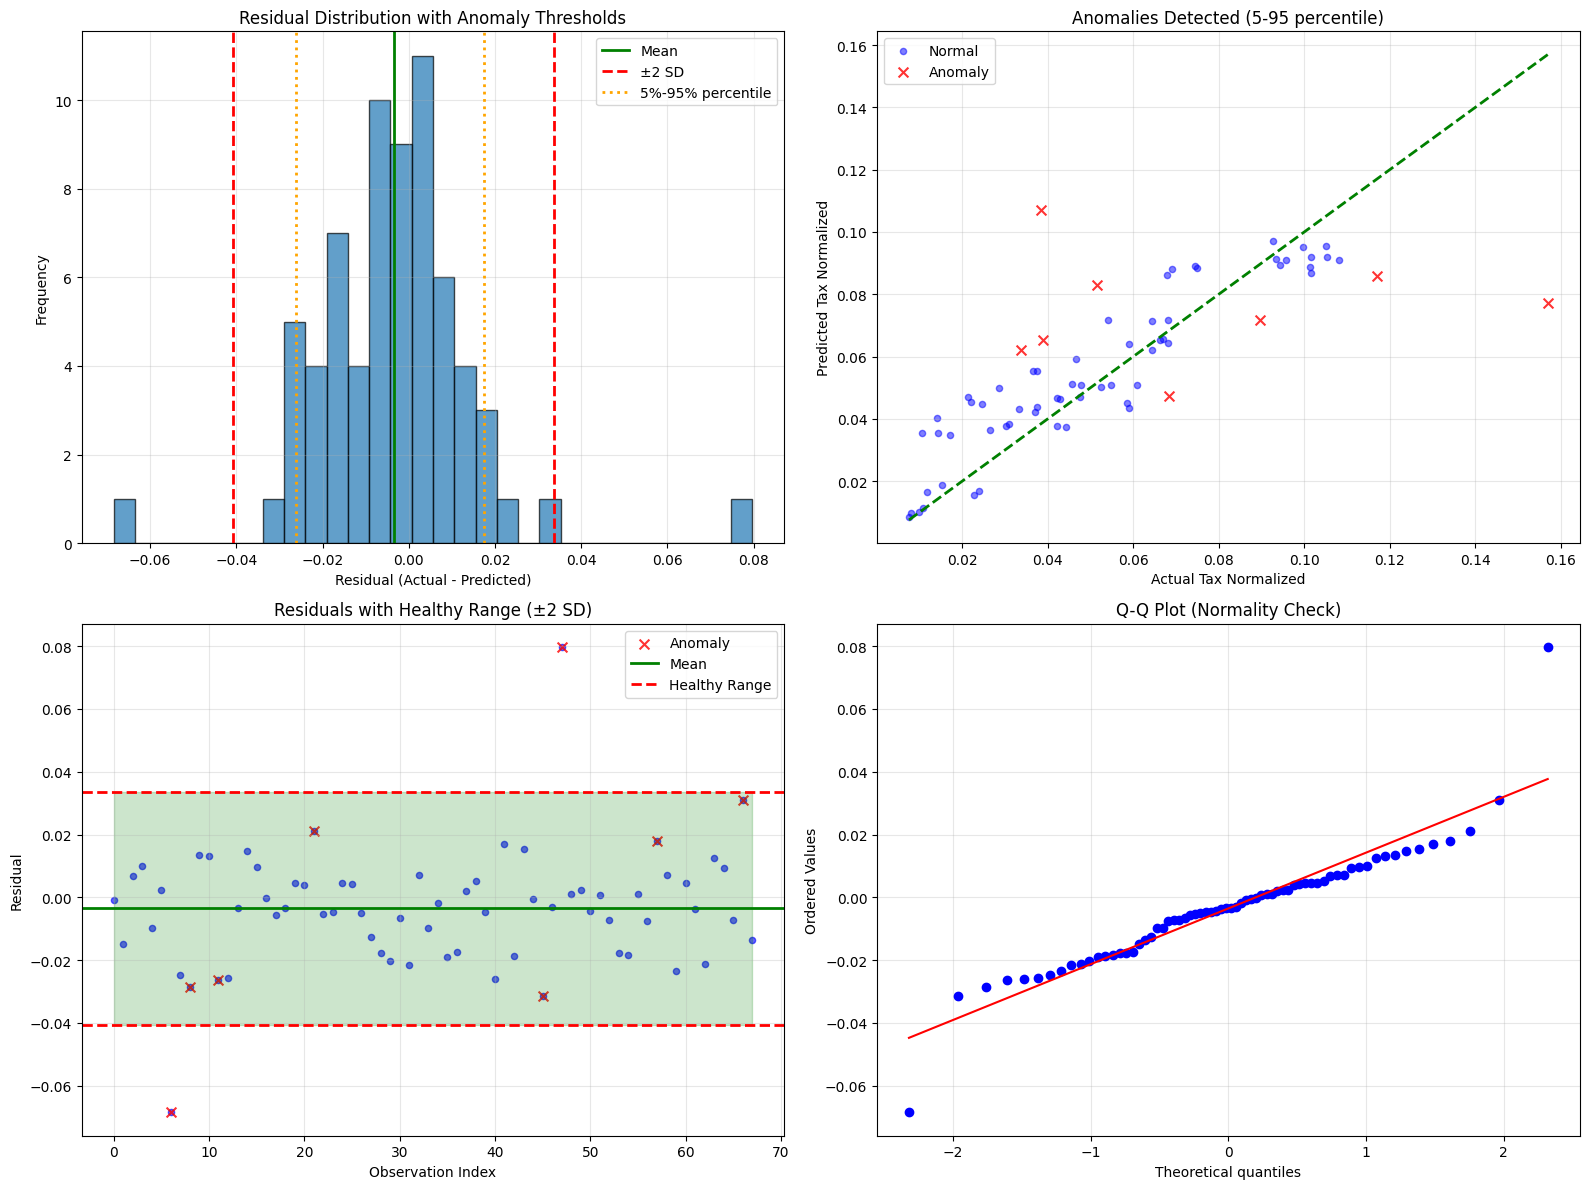

In [49]:
# Visualize healthy range and anomalies
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Residual distribution with thresholds
axes[0, 0].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(x=residual_mean, color='green', linestyle='-', linewidth=2, label='Mean')
axes[0, 0].axvline(x=residual_mean - threshold_2sd, color='red', linestyle='--', linewidth=2, label='±2 SD')
axes[0, 0].axvline(x=residual_mean + threshold_2sd, color='red', linestyle='--', linewidth=2)
axes[0, 0].axvline(x=threshold_p5, color='orange', linestyle=':', linewidth=2, label='5%-95% percentile')
axes[0, 0].axvline(x=threshold_p95, color='orange', linestyle=':', linewidth=2)
axes[0, 0].set_xlabel('Residual (Actual - Predicted)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Residual Distribution with Anomaly Thresholds')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Actual vs Predicted with anomalies highlighted
normal_mask = ~recommended_anomalies
axes[0, 1].scatter(y_test[normal_mask], y_pred_test_rf[normal_mask], 
                   alpha=0.5, s=20, color='blue', label='Normal')
axes[0, 1].scatter(y_test[recommended_anomalies], y_pred_test_rf[recommended_anomalies], 
                   alpha=0.8, s=50, color='red', marker='x', label='Anomaly')
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'g--', lw=2)
axes[0, 1].set_xlabel('Actual Tax Normalized')
axes[0, 1].set_ylabel('Predicted Tax Normalized')
axes[0, 1].set_title(f'Anomalies Detected ({recommended_method})')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Residuals over index with healthy range
axes[1, 0].scatter(range(len(residuals)), residuals, alpha=0.6, s=20, color='blue')
axes[1, 0].scatter(np.where(recommended_anomalies)[0], residuals[recommended_anomalies], 
                   alpha=0.8, s=50, color='red', marker='x', label='Anomaly')
axes[1, 0].axhline(y=residual_mean, color='green', linestyle='-', linewidth=2, label='Mean')
axes[1, 0].axhline(y=residual_mean - threshold_2sd, color='red', linestyle='--', linewidth=2, label='Healthy Range')
axes[1, 0].axhline(y=residual_mean + threshold_2sd, color='red', linestyle='--', linewidth=2)
axes[1, 0].fill_between(range(len(residuals)), 
                        residual_mean - threshold_2sd, 
                        residual_mean + threshold_2sd, 
                        alpha=0.2, color='green')
axes[1, 0].set_xlabel('Observation Index')
axes[1, 0].set_ylabel('Residual')
axes[1, 0].set_title('Residuals with Healthy Range (±2 SD)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Q-Q plot to assess normality
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot (Normality Check)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [48]:
# Flag anomalies using different methods
# Using 2 SD as recommended threshold (captures 95% of normal variation if normal)
anomalies_2sd = (residuals < (residual_mean - threshold_2sd)) | (residuals > (residual_mean + threshold_2sd))
anomalies_iqr = (residuals < threshold_iqr_lower) | (residuals > threshold_iqr_upper)
anomalies_p95 = (residuals < threshold_p5) | (residuals > threshold_p95)

print("Anomaly Detection Results")
print("="*50)
print(f"Total observations: {len(residuals)}")
print(f"\n±2 SD method:")
print(f"  Anomalies detected: {anomalies_2sd.sum()} ({100*anomalies_2sd.sum()/len(residuals):.1f}%)")
print(f"\nIQR method:")
print(f"  Anomalies detected: {anomalies_iqr.sum()} ({100*anomalies_iqr.sum()/len(residuals):.1f}%)")
print(f"\n5%-95% percentile method:")
print(f"  Anomalies detected: {anomalies_p95.sum()} ({100*anomalies_p95.sum()/len(residuals):.1f}%)")

# Recommended: Use 2 SD for normally distributed residuals, or 5-95 percentile if not normal
if p_value_normality > 0.05:
    print(f"\n✓ Recommended: Use ±2 SD method (residuals are normal)")
    recommended_anomalies = anomalies_2sd
    recommended_method = "±2 SD"
else:
    print(f"\n✓ Recommended: Use 5%-95% percentile method (residuals are not normal)")
    recommended_anomalies = anomalies_p95
    recommended_method = "5-95 percentile"

Anomaly Detection Results
Total observations: 68

±2 SD method:
  Anomalies detected: 2 (2.9%)

IQR method:
  Anomalies detected: 2 (2.9%)

5%-95% percentile method:
  Anomalies detected: 8 (11.8%)

✓ Recommended: Use 5%-95% percentile method (residuals are not normal)


In [47]:
# Define healthy ranges using multiple methods
residual_std = residuals.std()
residual_mean = residuals.mean()

# Method 1: Standard Deviation (assumes normal distribution)
threshold_2sd = 2 * residual_std
threshold_3sd = 3 * residual_std

# Method 2: IQR (Interquartile Range - robust to outliers)
q1 = np.percentile(residuals, 25)
q3 = np.percentile(residuals, 75)
iqr = q3 - q1
threshold_iqr_lower = q1 - 1.5 * iqr
threshold_iqr_upper = q3 + 1.5 * iqr

# Method 3: Percentile-based (most flexible)
threshold_p5 = np.percentile(residuals, 5)
threshold_p95 = np.percentile(residuals, 95)
threshold_p1 = np.percentile(residuals, 1)
threshold_p99 = np.percentile(residuals, 99)

print("\nAnomaly Detection Thresholds")
print("="*50)
print("\n1. Standard Deviation Method:")
print(f"   ±2 SD: [{residual_mean - threshold_2sd:.6f}, {residual_mean + threshold_2sd:.6f}]")
print(f"   ±3 SD: [{residual_mean - threshold_3sd:.6f}, {residual_mean + threshold_3sd:.6f}]")
print(f"   (Assumes normal distribution)")

print("\n2. IQR Method (Tukey's Fences):")
print(f"   Lower fence: {threshold_iqr_lower:.6f}")
print(f"   Upper fence: {threshold_iqr_upper:.6f}")
print(f"   (Robust to outliers)")

print("\n3. Percentile Method:")
print(f"   5%-95%: [{threshold_p5:.6f}, {threshold_p95:.6f}]  (flags 10% as anomalies)")
print(f"   1%-99%: [{threshold_p1:.6f}, {threshold_p99:.6f}]  (flags 2% as anomalies)")
print(f"   (Distribution-free)")


Anomaly Detection Thresholds

1. Standard Deviation Method:
   ±2 SD: [-0.040729, 0.033685]
   ±3 SD: [-0.059332, 0.052288]
   (Assumes normal distribution)

2. IQR Method (Tukey's Fences):
   Lower fence: -0.045714
   Upper fence: 0.035106
   (Robust to outliers)

3. Percentile Method:
   5%-95%: [-0.026150, 0.017493]  (flags 10% as anomalies)
   1%-99%: [-0.043586, 0.047078]  (flags 2% as anomalies)
   (Distribution-free)


In [46]:
# Calculate residuals from best model (Random Forest AR)
residuals = y_test - y_pred_test_rf

# Analyze residual distribution
print("Residual Analysis")
print("="*50)
print(f"Mean: {residuals.mean():.6f}")
print(f"Std Dev: {residuals.std():.6f}")
print(f"Min: {residuals.min():.6f}")
print(f"Max: {residuals.max():.6f}")
print(f"\nPercentiles:")
print(f"  1%: {np.percentile(residuals, 1):.6f}")
print(f"  5%: {np.percentile(residuals, 5):.6f}")
print(f"  25%: {np.percentile(residuals, 25):.6f}")
print(f"  50% (median): {np.percentile(residuals, 50):.6f}")
print(f"  75%: {np.percentile(residuals, 75):.6f}")
print(f"  95%: {np.percentile(residuals, 95):.6f}")
print(f"  99%: {np.percentile(residuals, 99):.6f}")

# Check if residuals are normally distributed
from scipy import stats
_, p_value_normality = stats.normaltest(residuals)
print(f"\nNormality test p-value: {p_value_normality:.4f}")
if p_value_normality > 0.05:
    print("✓ Residuals are approximately normal")
else:
    print("✗ Residuals are NOT normal (use percentile-based thresholds)")

Residual Analysis
Mean: -0.003522
Std Dev: 0.018603
Min: -0.068488
Max: 0.079693

Percentiles:
  1%: -0.043586
  5%: -0.026150
  25%: -0.015406
  50% (median): -0.003424
  75%: 0.004798
  95%: 0.017493
  99%: 0.047078

Normality test p-value: 0.0000
✗ Residuals are NOT normal (use percentile-based thresholds)


## Anomaly Detection Using Residuals

Define healthy ranges and flag anomalous tax submissions.

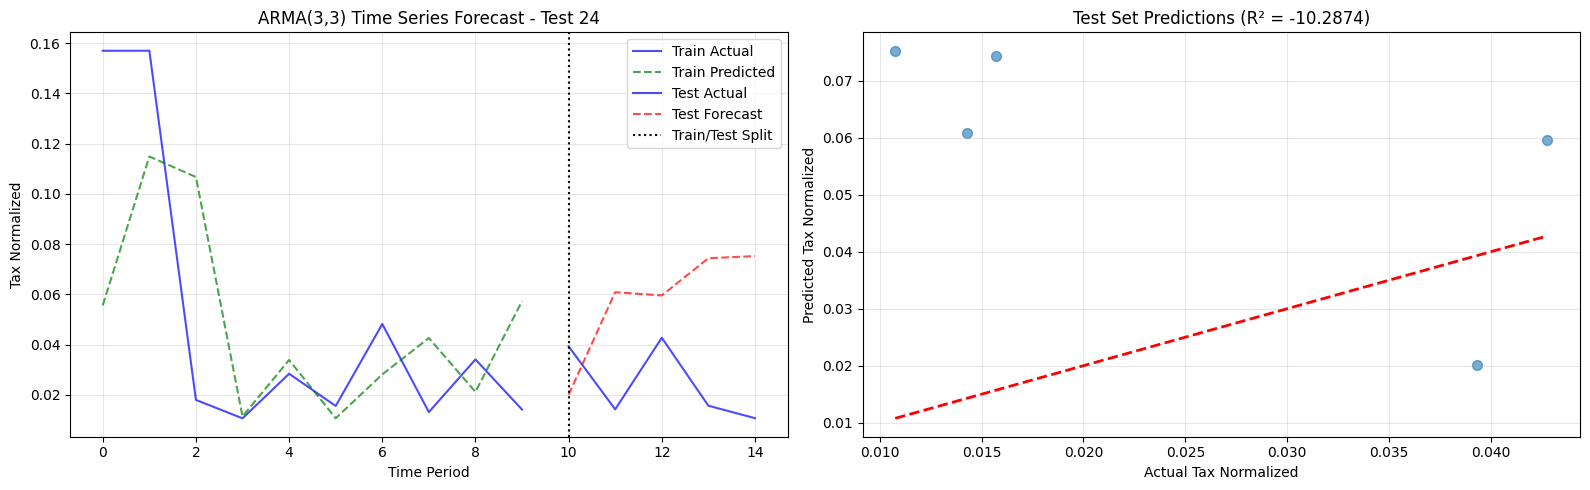

In [44]:
# Visualize ARMA predictions
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot time series with predictions
axes[0].plot(range(len(train_data)), train_data['Tax Normalized'].values, 'b-', label='Train Actual', alpha=0.7)
axes[0].plot(range(len(train_data)), train_pred_arma, 'g--', label='Train Predicted', alpha=0.7)
axes[0].plot(range(len(train_data), len(train_data) + len(test_data)), 
             test_data['Tax Normalized'].values, 'b-', label='Test Actual', alpha=0.7)
axes[0].plot(range(len(train_data), len(train_data) + len(test_data)), 
             forecast_arma, 'r--', label='Test Forecast', alpha=0.7)
axes[0].axvline(x=len(train_data), color='black', linestyle=':', label='Train/Test Split')
axes[0].set_xlabel('Time Period')
axes[0].set_ylabel('Tax Normalized')
axes[0].set_title(f'ARMA(3,3) Time Series Forecast - {largest_operator}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Scatter plot for test set
axes[1].scatter(test_data['Tax Normalized'], forecast_arma, alpha=0.6, s=50)
axes[1].plot([test_data['Tax Normalized'].min(), test_data['Tax Normalized'].max()],
             [test_data['Tax Normalized'].min(), test_data['Tax Normalized'].max()],
             'r--', lw=2)
axes[1].set_xlabel('Actual Tax Normalized')
axes[1].set_ylabel('Predicted Tax Normalized')
axes[1].set_title(f'Test Set Predictions (R² = {r2_score(test_data["Tax Normalized"], forecast_arma):.4f})')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [43]:
# Make predictions with ARMA model
# In-sample predictions
train_pred_arma = arma_fitted.fittedvalues

# Out-of-sample forecast
forecast_steps = len(test_data)
forecast_arma = arma_fitted.forecast(steps=forecast_steps)

# Evaluate ARMA performance
print("ARMA(3,3) Performance - Single Operator")
print("="*50)
print(f"Train R²: {r2_score(train_data['Tax Normalized'], train_pred_arma):.4f}")
print(f"Test R²: {r2_score(test_data['Tax Normalized'], forecast_arma):.4f}")
print(f"\nTrain MAE: {mean_absolute_error(train_data['Tax Normalized'], train_pred_arma):.6f}")
print(f"Test MAE: {mean_absolute_error(test_data['Tax Normalized'], forecast_arma):.6f}")
print(f"\nTrain RMSE: {np.sqrt(mean_squared_error(train_data['Tax Normalized'], train_pred_arma)):.6f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(test_data['Tax Normalized'], forecast_arma)):.6f}")

ARMA(3,3) Performance - Single Operator
Train R²: 0.2246
Test R²: -10.2874

Train MAE: 0.034872
Test MAE: 0.041159

Train RMSE: 0.048206
Test RMSE: 0.045657


/Users/nsambataufeeq/gaming-analytics/lgrb-preliminaries/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nsambataufeeq/gaming-analytics/lgrb-preliminaries/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [42]:
# Test ARMA model using statsmodels
from statsmodels.tsa.arima.model import ARIMA

# For ARMA, we need the full time series per operator
# Let's test on the largest operator first
largest_operator = ar_data['Operator Name'].value_counts().index[0]
operator_data = ar_data[ar_data['Operator Name'] == largest_operator].copy()
operator_data = operator_data.sort_index()

print(f"Testing ARMA on largest operator: {largest_operator}")
print(f"Data points: {len(operator_data)}")

# Train/test split (70/30)
train_size = int(len(operator_data) * 0.7)
train_data = operator_data.iloc[:train_size]
test_data = operator_data.iloc[train_size:]

# Fit ARMA(3,3) model - combining AR(3) and MA(3)
arma_model = ARIMA(train_data['Tax Normalized'], order=(3, 0, 3))
arma_fitted = arma_model.fit()

print("\nARMA(3,3) Model Summary:")
print(arma_fitted.summary())

Testing ARMA on largest operator: Test 24
Data points: 15

ARMA(3,3) Model Summary:
                               SARIMAX Results                                
Dep. Variable:         Tax Normalized   No. Observations:                   10
Model:                 ARIMA(3, 0, 3)   Log Likelihood                  17.046
Date:                Thu, 01 Jan 2026   AIC                            -18.091
Time:                        04:12:40   BIC                            -15.670
Sample:                             0   HQIC                           -20.747
                                 - 10                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0557      0.088      0.634      0.526      -0.116       0.228
ar.L1          1.1482      5.646      0.203    

/Users/nsambataufeeq/gaming-analytics/lgrb-preliminaries/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/nsambataufeeq/gaming-analytics/lgrb-preliminaries/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/nsambataufeeq/gaming-analytics/lgrb-preliminaries/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Use

## Test ARMA Model

Combine AR and MA components using ARMA model.

In [40]:
# Test MA model with Random Forest
ma_model_rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
ma_model_rf.fit(X_train_ma, y_train_ma)

y_pred_train_ma_rf = ma_model_rf.predict(X_train_ma)
y_pred_test_ma_rf = ma_model_rf.predict(X_test_ma)

print("Random Forest MA Model Performance")
print("="*50)
print(f"Train R²: {r2_score(y_train_ma, y_pred_train_ma_rf):.4f}")
print(f"Test R²: {r2_score(y_test_ma, y_pred_test_ma_rf):.4f}")
print(f"\nTrain MAE: {mean_absolute_error(y_train_ma, y_pred_train_ma_rf):.6f}")
print(f"Test MAE: {mean_absolute_error(y_test_ma, y_pred_test_ma_rf):.6f}")
print(f"\nTrain RMSE: {np.sqrt(mean_squared_error(y_train_ma, y_pred_train_ma_rf)):.6f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test_ma, y_pred_test_ma_rf)):.6f}")

print("\nFeature Importances:")
print(f"  MA(3): {ma_model_rf.feature_importances_[0]:.4f}")
print(f"  MA(7): {ma_model_rf.feature_importances_[1]:.4f}")
print(f"  MA(14): {ma_model_rf.feature_importances_[2]:.4f}")

Random Forest MA Model Performance
Train R²: 0.9102
Test R²: 0.3262

Train MAE: 0.006280
Test MAE: 0.019384

Train RMSE: 0.009662
Test RMSE: 0.034470

Feature Importances:
  MA(3): 0.6314
  MA(7): 0.1975
  MA(14): 0.1712


In [39]:
# Test MA model with Linear Regression
X_ma = ma_data[['tax_norm_ma3', 'tax_norm_ma7', 'tax_norm_ma14']]
y_ma = ma_data['Tax Normalized']

# Stratified split
X_train_ma, X_test_ma, y_train_ma, y_test_ma = train_test_split(
    X_ma, y_ma,
    test_size=0.3,
    random_state=42,
    stratify=ma_data['Operator Name']
)

# Linear MA model
ma_model_linear = LinearRegression()
ma_model_linear.fit(X_train_ma, y_train_ma)

y_pred_train_ma_lin = ma_model_linear.predict(X_train_ma)
y_pred_test_ma_lin = ma_model_linear.predict(X_test_ma)

print("Linear MA Model Performance")
print("="*50)
print(f"Train R²: {r2_score(y_train_ma, y_pred_train_ma_lin):.4f}")
print(f"Test R²: {r2_score(y_test_ma, y_pred_test_ma_lin):.4f}")
print(f"\nTrain MAE: {mean_absolute_error(y_train_ma, y_pred_train_ma_lin):.6f}")
print(f"Test MAE: {mean_absolute_error(y_test_ma, y_pred_test_ma_lin):.6f}")
print(f"\nTrain RMSE: {np.sqrt(mean_squared_error(y_train_ma, y_pred_train_ma_lin)):.6f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test_ma, y_pred_test_ma_lin)):.6f}")

print(f"\nModel coefficients:")
print(f"  MA(3): {ma_model_linear.coef_[0]:.4f}")
print(f"  MA(7): {ma_model_linear.coef_[1]:.4f}")
print(f"  MA(14): {ma_model_linear.coef_[2]:.4f}")

Linear MA Model Performance
Train R²: 0.5564
Test R²: 0.3214

Train MAE: 0.014388
Test MAE: 0.018690

Train RMSE: 0.021482
Test RMSE: 0.034594

Model coefficients:
  MA(3): 0.4191
  MA(7): 0.5223
  MA(14): -0.1961


In [38]:
# Create MA features - rolling mean of Tax Normalized (moving averages)
general_betting_df_ma = general_betting_df.copy()

# Create moving average features grouped by operator
general_betting_df_ma['tax_norm_ma3'] = general_betting_df_ma.groupby('Operator Name')['Tax Normalized'].transform(lambda x: x.rolling(window=3, min_periods=1).mean().shift(1))
general_betting_df_ma['tax_norm_ma7'] = general_betting_df_ma.groupby('Operator Name')['Tax Normalized'].transform(lambda x: x.rolling(window=7, min_periods=1).mean().shift(1))
general_betting_df_ma['tax_norm_ma14'] = general_betting_df_ma.groupby('Operator Name')['Tax Normalized'].transform(lambda x: x.rolling(window=14, min_periods=1).mean().shift(1))

# Drop rows with NaN
ma_data = general_betting_df_ma[['Tax Normalized', 'tax_norm_ma3', 'tax_norm_ma7', 'tax_norm_ma14', 'Operator Name']].dropna()

print(f"MA dataset shape: {ma_data.shape}")
print(f"Observations per operator:")
print(ma_data['Operator Name'].value_counts())

MA dataset shape: (277, 5)
Observations per operator:
Operator Name
Test 24     17
Test 10     11
Test 32     11
Test 9      11
Test 6      11
Test 52     11
Test 5      11
Test 42     11
Test 38     11
Test 35     11
Test 11     11
Test 34     11
Test 3      11
Test 29     11
Test 28     11
Test 20     11
Test 2      11
Test 19     11
Test 16     11
Test 15     11
Testr 48    11
Test 46     10
Test 44      9
Test 4       8
Test 41      8
Test 17      5
Name: count, dtype: int64


## Test MA (Moving Average) Model

Test MA model using past forecast errors as predictors.

In [36]:
# Compare all models
comparison = pd.DataFrame({
    'Model': ['Linear AR', 'Random Forest', 'XGBoost'],
    'Train R²': [
        r2_score(y_train, y_pred_train),
        r2_score(y_train, y_pred_train_rf),
        r2_score(y_train, y_pred_train_xgb)
    ],
    'Test R²': [
        r2_score(y_test, y_pred_test),
        r2_score(y_test, y_pred_test_rf),
        r2_score(y_test, y_pred_test_xgb)
    ],
    'Test MAE': [
        mean_absolute_error(y_test, y_pred_test),
        mean_absolute_error(y_test, y_pred_test_rf),
        mean_absolute_error(y_test, y_pred_test_xgb)
    ],
    'Test RMSE': [
        np.sqrt(mean_squared_error(y_test, y_pred_test)),
        np.sqrt(mean_squared_error(y_test, y_pred_test_rf)),
        np.sqrt(mean_squared_error(y_test, y_pred_test_xgb))
    ]
})

print("\nModel Comparison")
print("="*80)
print(comparison.to_string(index=False))

# Highlight best model
best_model = comparison.loc[comparison['Test R²'].idxmax(), 'Model']
print(f"\nBest model by Test R²: {best_model}")


Model Comparison
        Model  Train R²  Test R²  Test MAE  Test RMSE
    Linear AR  0.377381 0.389135  0.017802   0.025074
Random Forest  0.900601 0.656618  0.013006   0.018799
      XGBoost  0.988230 0.656202  0.013473   0.018810

Best model by Test R²: Random Forest


In [35]:
# Test XGBoost
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)

y_pred_train_xgb = xgb_model.predict(X_train)
y_pred_test_xgb = xgb_model.predict(X_test)

print("XGBoost Performance")
print("="*50)
print(f"Train R²: {r2_score(y_train, y_pred_train_xgb):.4f}")
print(f"Test R²: {r2_score(y_test, y_pred_test_xgb):.4f}")
print(f"\nTrain MAE: {mean_absolute_error(y_train, y_pred_train_xgb):.6f}")
print(f"Test MAE: {mean_absolute_error(y_test, y_pred_test_xgb):.6f}")
print(f"\nTrain RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train_xgb)):.6f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test_xgb)):.6f}")

print("\nFeature Importances:")
for i, importance in enumerate(xgb_model.feature_importances_, 1):
    print(f"  Lag {i}: {importance:.4f}")

XGBoost Performance
Train R²: 0.9882
Test R²: 0.6562

Train MAE: 0.002836
Test MAE: 0.013473

Train RMSE: 0.003948
Test RMSE: 0.018810

Feature Importances:
  Lag 1: 0.4940
  Lag 2: 0.1295
  Lag 3: 0.3765


In [34]:
# Test Random Forest
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

y_pred_train_rf = rf_model.predict(X_train)
y_pred_test_rf = rf_model.predict(X_test)

print("Random Forest Performance")
print("="*50)
print(f"Train R²: {r2_score(y_train, y_pred_train_rf):.4f}")
print(f"Test R²: {r2_score(y_test, y_pred_test_rf):.4f}")
print(f"\nTrain MAE: {mean_absolute_error(y_train, y_pred_train_rf):.6f}")
print(f"Test MAE: {mean_absolute_error(y_test, y_pred_test_rf):.6f}")
print(f"\nTrain RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train_rf)):.6f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test_rf)):.6f}")

print("\nFeature Importances:")
for i, importance in enumerate(rf_model.feature_importances_, 1):
    print(f"  Lag {i}: {importance:.4f}")

Random Forest Performance
Train R²: 0.9006
Test R²: 0.6566

Train MAE: 0.006624
Test MAE: 0.013006

Train RMSE: 0.011473
Test RMSE: 0.018799

Feature Importances:
  Lag 1: 0.5220
  Lag 2: 0.2035
  Lag 3: 0.2746


## Test Non-Linear Models

Compare Random Forest and XGBoost against linear AR model.

In [32]:
# Compare train and test statistics with fixed split
print("Fixed Split - Train Set Statistics:")
print(f"  Mean: {y_train.mean():.6f}")
print(f"  Std: {y_train.std():.6f}")
print(f"  Min: {y_train.min():.6f}")
print(f"  Max: {y_train.max():.6f}")
print(f"  Size: {len(y_train)}")

print("\nFixed Split - Test Set Statistics:")
print(f"  Mean: {y_test.mean():.6f}")
print(f"  Std: {y_test.std():.6f}")
print(f"  Min: {y_test.min():.6f}")
print(f"  Max: {y_test.max():.6f}")
print(f"  Size: {len(y_test)}")

print(f"\nTest/Train Mean Ratio: {y_test.mean() / y_train.mean():.4f}")
print(f"Test/Train Std Ratio: {y_test.std() / y_train.std():.4f}")

Fixed Split - Train Set Statistics:
  Mean: 0.058025
  Std: 0.036506
  Min: 0.006635
  Max: 0.302625
  Size: 157

Fixed Split - Test Set Statistics:
  Mean: 0.053953
  Std: 0.032319
  Min: 0.007577
  Max: 0.156933
  Size: 68

Test/Train Mean Ratio: 0.9298
Test/Train Std Ratio: 0.8853


In [31]:
# Better split: stratify by operator to ensure each operator is in both train and test
from sklearn.model_selection import train_test_split

X = ar_data[['tax_norm_lag1', 'tax_norm_lag2', 'tax_norm_lag3']]
y = ar_data['Tax Normalized']

# Stratified split by operator (70/30)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42,
    stratify=ar_data['Operator Name']
)

# Train AR model
ar_model_fixed = LinearRegression()
ar_model_fixed.fit(X_train, y_train)

# Predictions
y_pred_train = ar_model_fixed.predict(X_train)
y_pred_test = ar_model_fixed.predict(X_test)

# Evaluate
print("AR Model Performance (Fixed Split)")
print("="*50)
print(f"Train R²: {r2_score(y_train, y_pred_train):.4f}")
print(f"Test R²: {r2_score(y_test, y_pred_test):.4f}")
print(f"\nTrain MAE: {mean_absolute_error(y_train, y_pred_train):.6f}")
print(f"Test MAE: {mean_absolute_error(y_test, y_pred_test):.6f}")
print(f"\nTrain RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.6f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.6f}")

print(f"\nModel coefficients:")
for i, coef in enumerate(ar_model_fixed.coef_, 1):
    print(f"  Lag {i}: {coef:.4f}")

AR Model Performance (Fixed Split)
Train R²: 0.3774
Test R²: 0.3891

Train MAE: 0.016005
Test MAE: 0.017802

Train RMSE: 0.028714
Test RMSE: 0.025074

Model coefficients:
  Lag 1: 0.2888
  Lag 2: 0.0722
  Lag 3: 0.3812


## Fix Train/Test Split - Use Stratified Sampling

Ensure both train and test have representative samples from each operator.

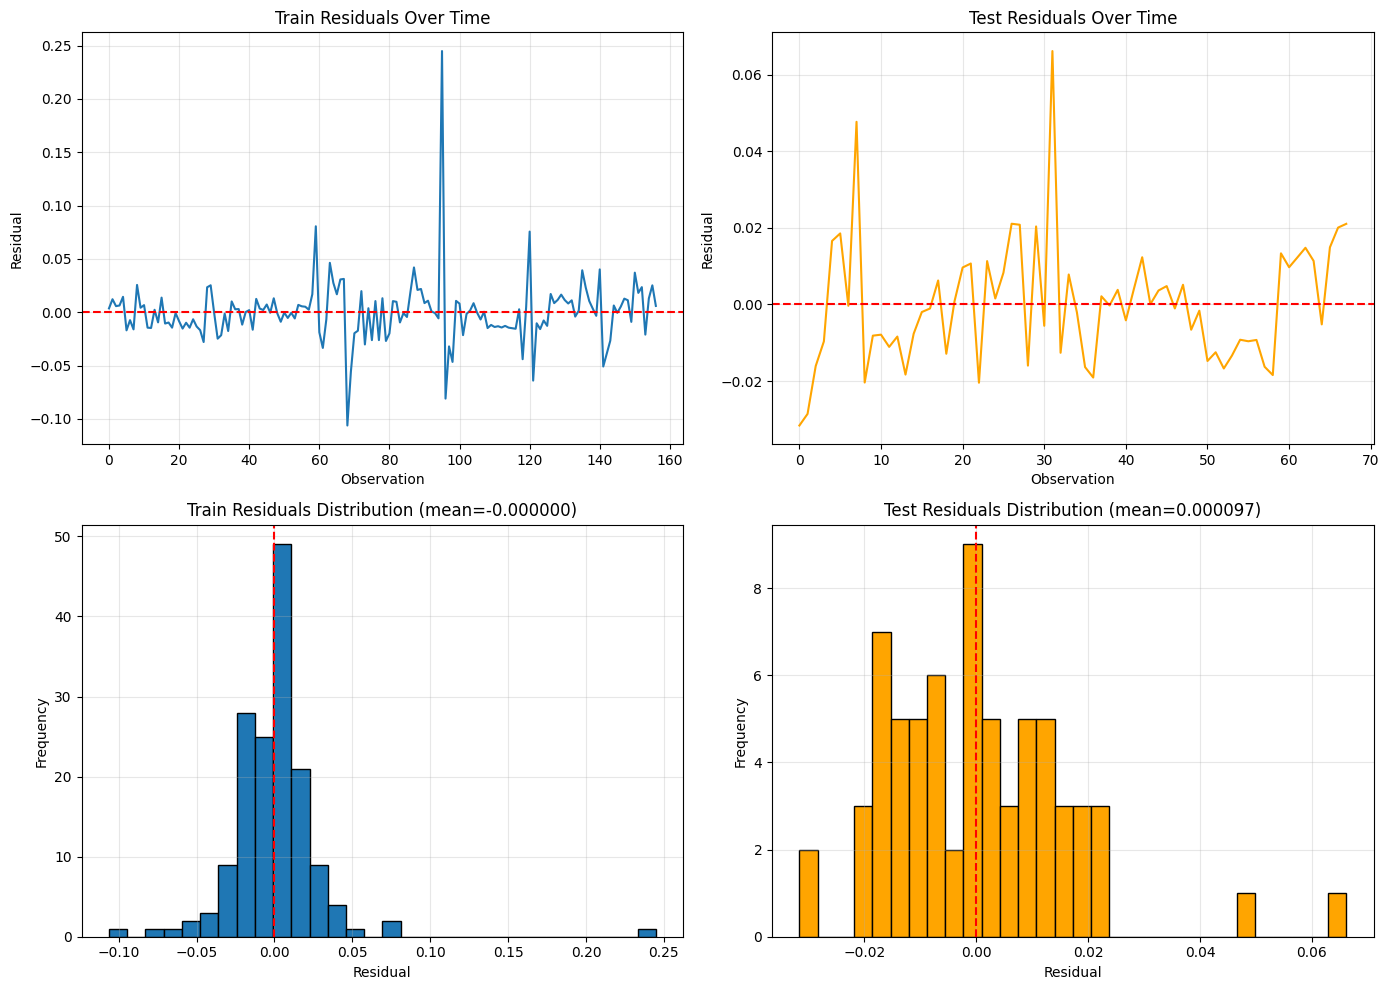

Train residuals std: 0.030283
Test residuals std: 0.016343


In [29]:
# Check residuals for AR model
residuals_train = y_train - y_pred_train
residuals_test = y_test - y_pred_test

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Train residuals over time
axes[0, 0].plot(residuals_train.values)
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].set_title('Train Residuals Over Time')
axes[0, 0].set_xlabel('Observation')
axes[0, 0].set_ylabel('Residual')
axes[0, 0].grid(True, alpha=0.3)

# Test residuals over time
axes[0, 1].plot(residuals_test.values, color='orange')
axes[0, 1].axhline(y=0, color='r', linestyle='--')
axes[0, 1].set_title('Test Residuals Over Time')
axes[0, 1].set_xlabel('Observation')
axes[0, 1].set_ylabel('Residual')
axes[0, 1].grid(True, alpha=0.3)

# Train residuals distribution
axes[1, 0].hist(residuals_train, bins=30, edgecolor='black')
axes[1, 0].axvline(x=0, color='r', linestyle='--')
axes[1, 0].set_title(f'Train Residuals Distribution (mean={residuals_train.mean():.6f})')
axes[1, 0].set_xlabel('Residual')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True, alpha=0.3)

# Test residuals distribution
axes[1, 1].hist(residuals_test, bins=30, edgecolor='black', color='orange')
axes[1, 1].axvline(x=0, color='r', linestyle='--')
axes[1, 1].set_title(f'Test Residuals Distribution (mean={residuals_test.mean():.6f})')
axes[1, 1].set_xlabel('Residual')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Train residuals std: {residuals_train.std():.6f}")
print(f"Test residuals std: {residuals_test.std():.6f}")

In [28]:
# Investigate train/test split - check if there's a systematic difference
print("Train Set Statistics:")
print(f"  Mean: {y_train.mean():.6f}")
print(f"  Std: {y_train.std():.6f}")
print(f"  Min: {y_train.min():.6f}")
print(f"  Max: {y_train.max():.6f}")
print(f"  Size: {len(y_train)}")

print("\nTest Set Statistics:")
print(f"  Mean: {y_test.mean():.6f}")
print(f"  Std: {y_test.std():.6f}")
print(f"  Min: {y_test.min():.6f}")
print(f"  Max: {y_test.max():.6f}")
print(f"  Size: {len(y_test)}")

print(f"\nTest/Train Mean Ratio: {y_test.mean() / y_train.mean():.4f}")
print(f"Test/Train Std Ratio: {y_test.std() / y_train.std():.4f}")

Train Set Statistics:
  Mean: 0.058400
  Std: 0.037771
  Min: 0.007946
  Max: 0.302625
  Size: 157

Test Set Statistics:
  Mean: 0.053087
  Std: 0.028593
  Min: 0.006635
  Max: 0.132929
  Size: 68

Test/Train Mean Ratio: 0.9090
Test/Train Std Ratio: 0.7570


In [27]:
# Test for stationarity using Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

def adf_test(series, name):
    result = adfuller(series.dropna())
    print(f'\nADF Test Results for {name}:')
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'  {key}: {value:.3f}')
    
    if result[1] <= 0.05:
        print(f"✓ Series is STATIONARY (p-value = {result[1]:.4f})")
    else:
        print(f"✗ Series is NON-STATIONARY (p-value = {result[1]:.4f})")
    
    return result[1]

# Test Tax Normalized for stationarity
p_value = adf_test(ar_data['Tax Normalized'], 'Tax Normalized')


ADF Test Results for Tax Normalized:
ADF Statistic: -6.136485
p-value: 0.000000
Critical Values:
  1%: -3.460
  5%: -2.875
  10%: -2.574
✓ Series is STATIONARY (p-value = 0.0000)


## Stationarity Tests and Model Diagnostics

Check AR model assumptions and investigate suspicious test performance.

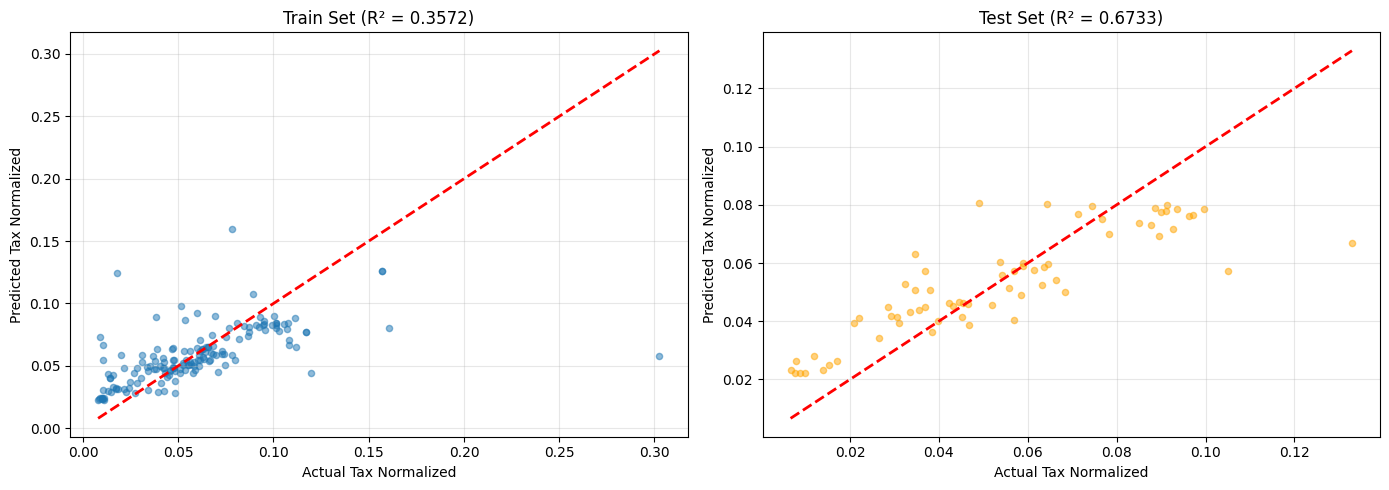

In [25]:
# Visualize predictions vs actual
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Train set
axes[0].scatter(y_train, y_pred_train, alpha=0.5, s=20)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Tax Normalized')
axes[0].set_ylabel('Predicted Tax Normalized')
axes[0].set_title(f'Train Set (R² = {r2_score(y_train, y_pred_train):.4f})')
axes[0].grid(True, alpha=0.3)

# Test set
axes[1].scatter(y_test, y_pred_test, alpha=0.5, s=20, color='orange')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Tax Normalized')
axes[1].set_ylabel('Predicted Tax Normalized')
axes[1].set_title(f'Test Set (R² = {r2_score(y_test, y_pred_test):.4f})')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [24]:
# Build AR model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Prepare features and target
X = ar_data[['tax_norm_lag1', 'tax_norm_lag2', 'tax_norm_lag3']]
y = ar_data['Tax Normalized']

# Chronological split (70% train, 30% test)
split_idx = int(len(ar_data) * 0.7)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Train AR model
ar_model = LinearRegression()
ar_model.fit(X_train, y_train)

# Predictions
y_pred_train = ar_model.predict(X_train)
y_pred_test = ar_model.predict(X_test)

# Evaluate
print("AR Model Performance")
print("="*50)
print(f"Train R²: {r2_score(y_train, y_pred_train):.4f}")
print(f"Test R²: {r2_score(y_test, y_pred_test):.4f}")
print(f"\nTrain MAE: {mean_absolute_error(y_train, y_pred_train):.6f}")
print(f"Test MAE: {mean_absolute_error(y_test, y_pred_test):.6f}")
print(f"\nTrain RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.6f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.6f}")

print(f"\nModel coefficients:")
for i, coef in enumerate(ar_model.coef_, 1):
    print(f"  Lag {i}: {coef:.4f}")

AR Model Performance
Train R²: 0.3572
Test R²: 0.6733

Train MAE: 0.017561
Test MAE: 0.012290

Train RMSE: 0.030186
Test RMSE: 0.016222

Model coefficients:
  Lag 1: 0.4170
  Lag 2: 0.1109
  Lag 3: 0.1565


In [23]:
# Create lagged features for AR model
general_betting_df = general_betting_df.copy()

# Create lags grouped by operator (assuming each operator has time series)
general_betting_df['tax_norm_lag1'] = general_betting_df.groupby('Operator Name')['Tax Normalized'].shift(1)
general_betting_df['tax_norm_lag2'] = general_betting_df.groupby('Operator Name')['Tax Normalized'].shift(2)
general_betting_df['tax_norm_lag3'] = general_betting_df.groupby('Operator Name')['Tax Normalized'].shift(3)

# Drop rows with NaN lags
ar_data = general_betting_df[['Tax Normalized', 'tax_norm_lag1', 'tax_norm_lag2', 'tax_norm_lag3', 'Operator Name']].dropna()

print(f"AR dataset shape: {ar_data.shape}")
print(f"Observations per operator:")
print(ar_data['Operator Name'].value_counts())

AR dataset shape: (225, 5)
Observations per operator:
Operator Name
Test 24     15
Test 10      9
Test 32      9
Test 9       9
Test 6       9
Test 52      9
Test 5       9
Test 42      9
Test 38      9
Test 35      9
Test 11      9
Test 34      9
Test 3       9
Test 29      9
Test 28      9
Test 20      9
Test 2       9
Test 19      9
Test 16      9
Test 15      9
Testr 48     9
Test 46      8
Test 44      7
Test 4       6
Test 41      6
Test 17      3
Name: count, dtype: int64


In [22]:
# Identify date/period column and sort data
date_cols = [col for col in general_betting_df.columns if any(x in col.lower() for x in ['date', 'period', 'month', 'quarter', 'year'])]
print("Date-related columns:", date_cols)

# Sort by operator and date for time series analysis
if date_cols:
    date_col = date_cols[0]
    general_betting_df = general_betting_df.sort_values(['Operator Name', date_col])
    print(f"\nData sorted by Operator Name and {date_col}")
    print(f"Date range: {general_betting_df[date_col].min()} to {general_betting_df[date_col].max()}")
else:
    print("\nNo clear date column found - checking all columns for temporal info")

Date-related columns: ['Date', 'Quarters']

Data sorted by Operator Name and Date
Date range: 2024-07-31 00:00:00 to 2025-06-30 00:00:00


In [21]:
# Check for temporal columns
print("Columns in dataset:")
print(general_betting_df.columns.tolist())
print("\nDataFrame shape:", general_betting_df.shape)

Columns in dataset:
['SRN', 'Operator Category', 'Operator Name', 'TIN', 'Date', 'Quarters', 'Total Sales', 'Total Payouts', 'Win/Loss', 'Withholding Tax', 'Gaming Tax', 'Total Expected Tax', 'Unnamed: 12', 'Unnamed: 13', 'Tax Normalized']

DataFrame shape: (321, 15)


## Test AR Model for Normalized Tax Prediction

Check if temporal structure exists and test autoregressive model performance.